In [1]:
import cartopy.crs as ccrs
import gcsfs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cftime
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
fs = gcsfs.GCSFileSystem()

In [3]:
fs.ls('gs://leap-persistent/yiqioyang')

['leap-persistent/yiqioyang/cam6_PD_monthly_lwsw.zarr',
 'leap-persistent/yiqioyang/cam6_PD_monthly_prec.zarr',
 'leap-persistent/yiqioyang/gisse3ensemble_radiation_tcc_tlwp.zarr',
 'leap-persistent/yiqioyang/selected_cam6_fields.1yearave.nc',
 'leap-persistent/yiqioyang/selected_cam6_fields.1yearave.zarr',
 'leap-persistent/yiqioyang/selected_cam6_fields.2yearave.zarr',
 'leap-persistent/yiqioyang/selected_cam6_fields.3yearave.zarr',
 'leap-persistent/yiqioyang/testing',
 'leap-persistent/yiqioyang/tparams_gcmglobalaverages.CAM6tuningexp.v1.obsbias_used.1yearave.nc.zarr',
 'leap-persistent/yiqioyang/tparams_gcmglobalaverages.CAM6tuningexp.v1.obsbias_used.2yearave.nc.zarr',
 'leap-persistent/yiqioyang/tparams_gcmglobalaverages.CAM6tuningexp.v1.obsbias_used.3yearave.nc.zarr']

In [4]:
param_xr = xr.open_dataset('parameter_262_w_control.nc')

In [5]:
param_df = param_xr.to_pandas()
param_df = param_df.drop('Sample_nmb', axis=1)

In [6]:
param_std_df = (param_df - param_df.min()) / (param_df.max() - param_df.min())

Constrained index values from constraining_ppe.ipynb. See ensemble_mems[best\_indx]

In [59]:
constrained_index = [253, 153, 126, 197, 103,  76,  39, 0, 258, 226]

In [8]:
amip_p90 = xr.open_dataset('amip_prec_q90_97-99.nc')

In [9]:
amip_p90 = (amip_p90.
            assign_coords({'ensemble': np.arange(10)}).
            drop_vars('quantile'))

In [10]:
amip_p90['PREC']

<xarray.DataArray 'PREC' (ensemble: 10, lat: 192, lon: 288)> Size: 4MB
[552960 values with dtype=float64]
Coordinates:
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * ensemble  (ensemble) int64 80B 0 1 2 3 4 5 6 7 8 9

# Find 0.90 Quantile of PRECT

In [12]:
mapper = fs.get_mapper("gs://leap-persistent/yiqioyang/cam6_PD_monthly_prec.zarr")
prec_ppe_xr = xr.open_dataset(mapper, engine = 'zarr')

In [30]:
prec_ppe_xr = prec_ppe_xr.chunk({'ensemble': 262, 'time': 36, 'lat': 64, 'lon': 64})

In [31]:
prec_ppe_xr['PRECC']

<xarray.DataArray 'PRECC' (ensemble: 262, time: 36, lat: 192, lon: 288)> Size: 2GB
dask.array<xarray-PRECC, shape=(262, 36, 192, 288), dtype=float32, chunksize=(262, 36, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * ensemble  (ensemble) int64 2kB 0 1 2 3 4 5 6 ... 256 257 258 259 260 261 262
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time      (time) object 288B 0001-01-16 12:00:00 ... 0003-12-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Convective precipitation rate (liq + ice)
    units:         m/s

In [32]:
prect_ppe = prec_ppe_xr['PRECC'] + prec_ppe_xr['PRECL']

In [33]:
prect_ppe.name = 'PRECT'
prect_ppe = prect_ppe.assign_attrs(units='mm/day')

In [34]:
prect_ppe = prect_ppe * (60 * 60 * 24 * 1000.)

In [11]:
prect_ppe_q90 = prect_ppe.quantile(0.9, 'time')

NameError: name 'prect_ppe' is not defined

In [17]:
prect_ppe_q90.to_netcdf('prect_ppe_q90_mmd.nc')

# Constrained Params

In [13]:
param_const = param_std_df.iloc[constrained_index]

<Axes: >

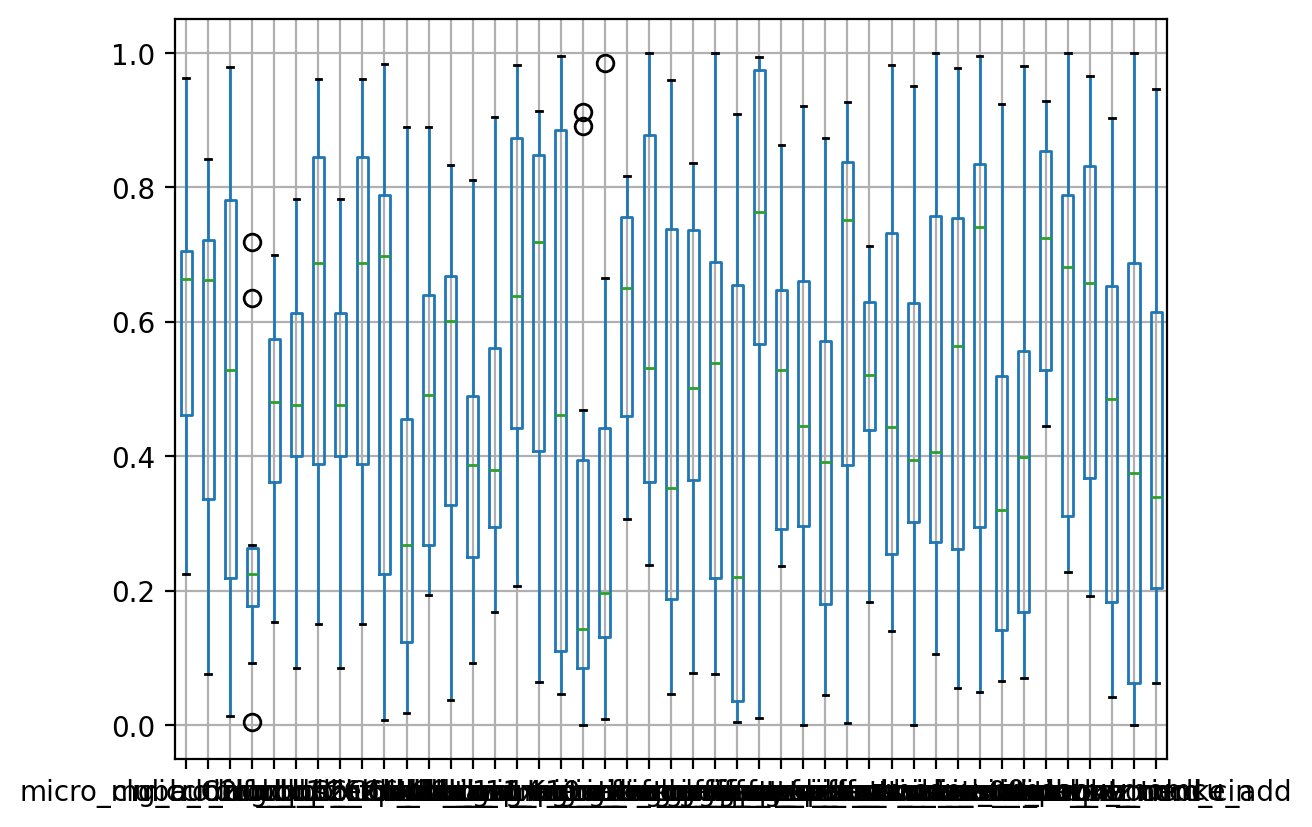

In [14]:
param_const.boxplot()

In [15]:
param_mins = param_const.min()
param_maxes = param_const.max()

<Axes: >

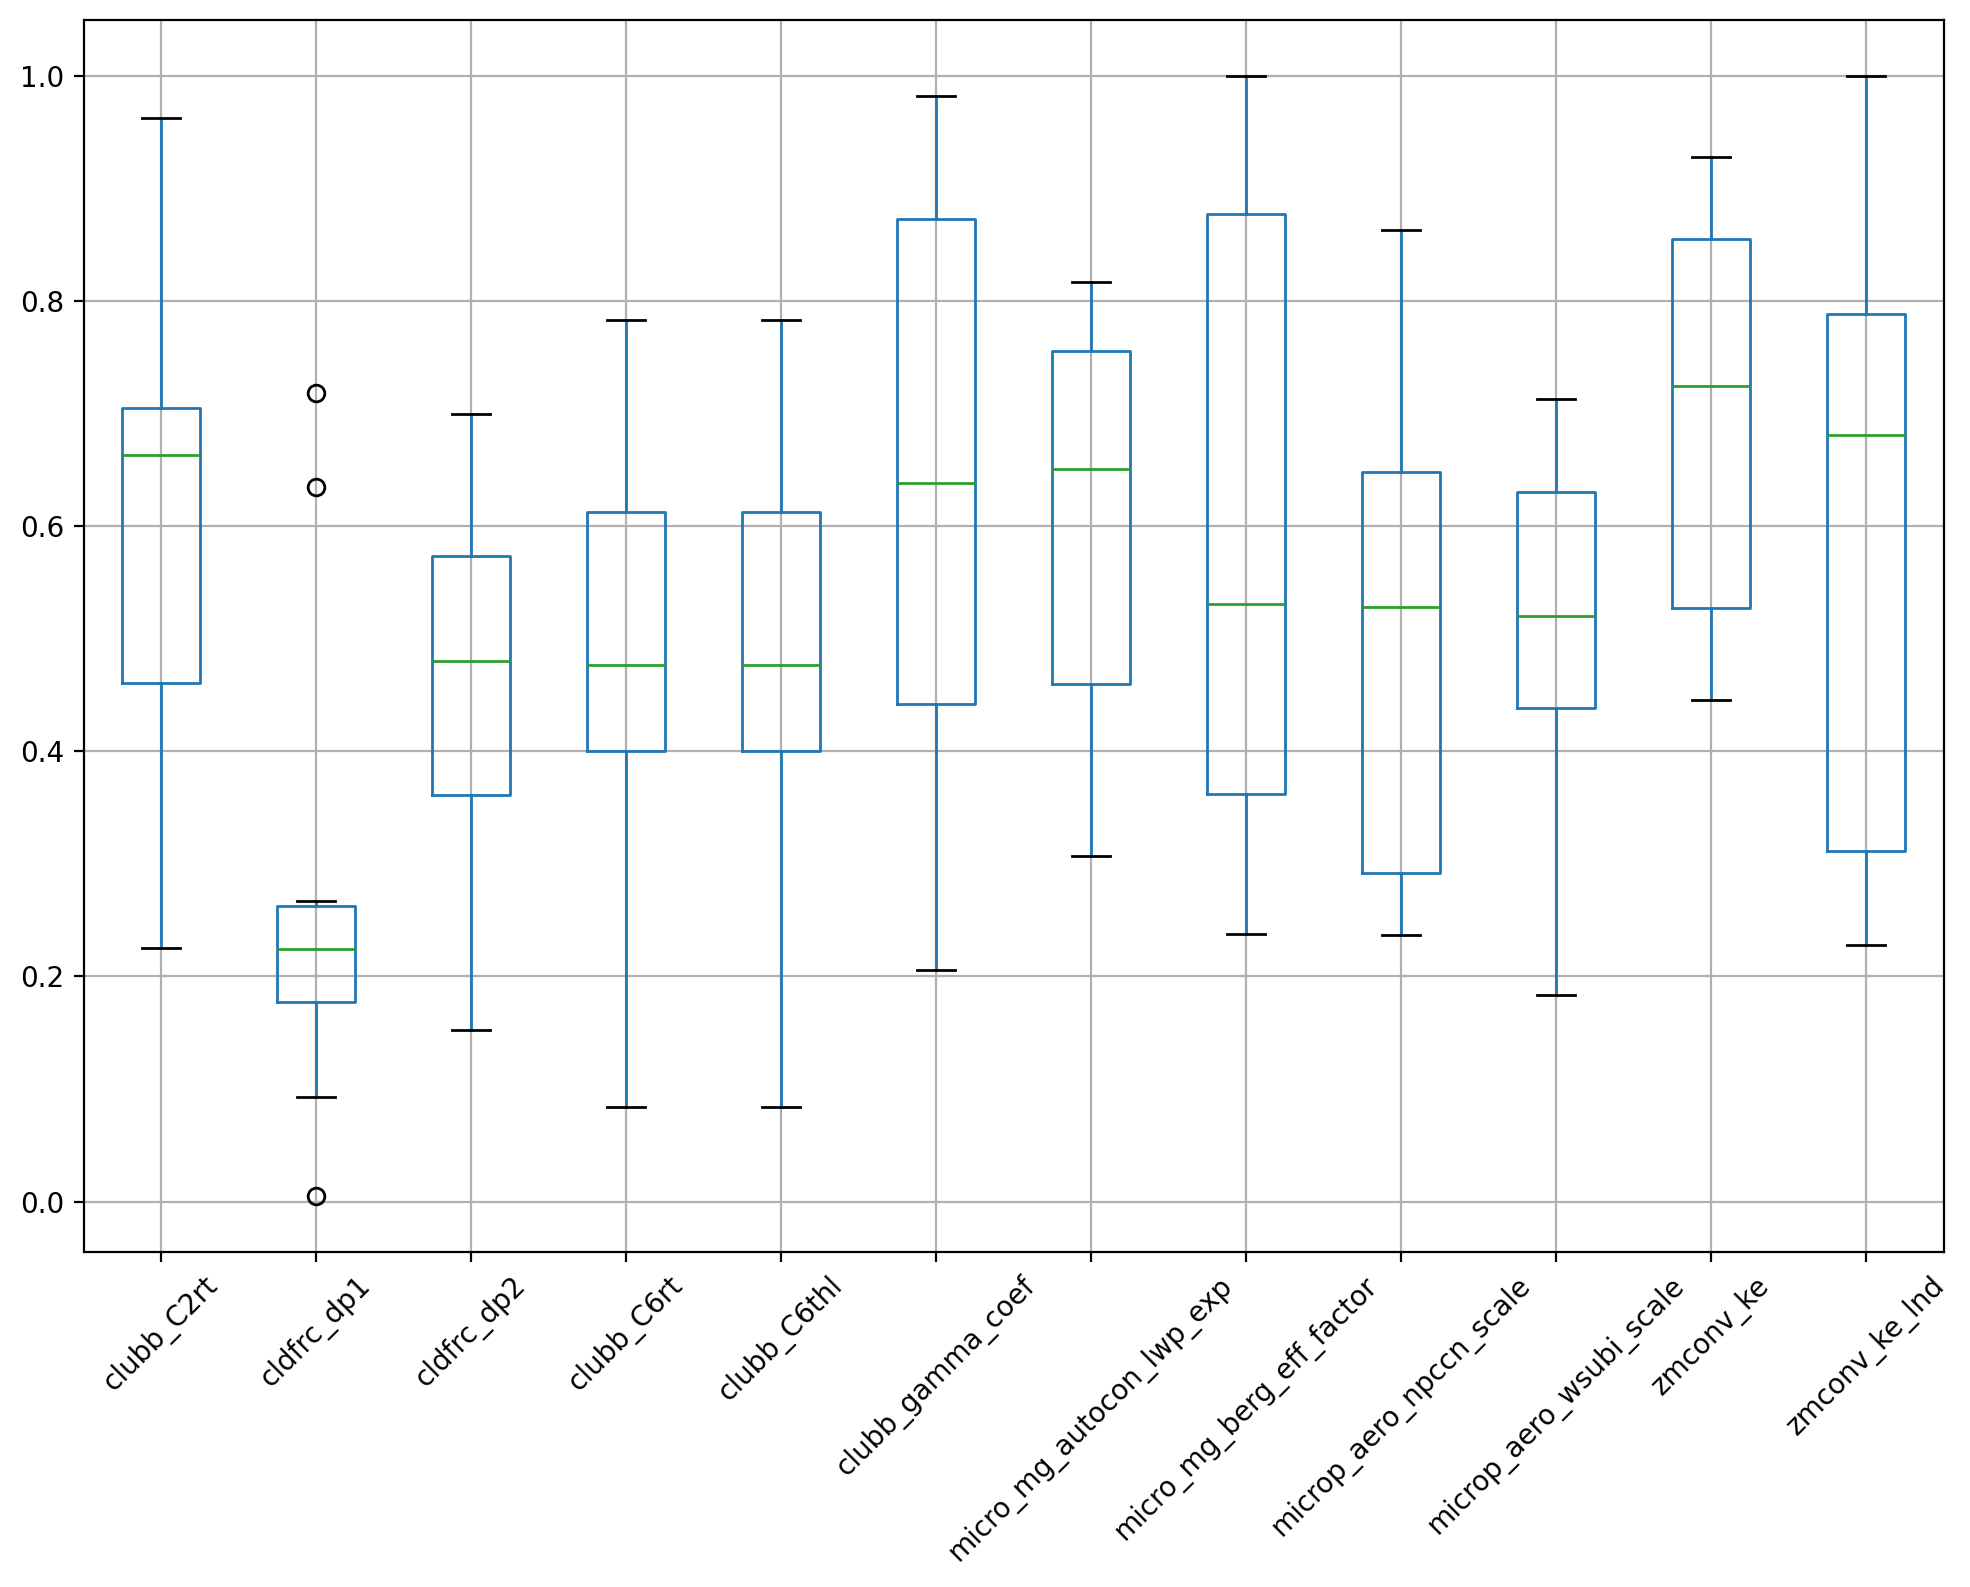

In [16]:
param_const.loc[:, (param_maxes < 0.8) | (param_mins > 0.2)].boxplot(figsize=(12, 8),
                                                                    rot = 45)

In [17]:
param_range = (param_const.max() - param_const.min())

In [18]:
param_range.sort_values()

zmconv_ke                    0.482599
micro_mg_autocon_lwp_exp     0.509556
microp_aero_wsubi_scale      0.530181
cldfrc_dp2                   0.547236
microp_aero_npccn_scale      0.626885
clubb_c1                     0.696369
clubb_C6rt                   0.698713
clubb_C6thl                  0.698713
cldfrc_dp1                   0.712983
clubb_c14                    0.718699
clubb_c_K10                  0.737096
clubb_C2rt                   0.737260
micro_mg_homog_size          0.759275
micro_mg_berg_eff_factor     0.762634
micro_mg_autocon_nd_exp      0.767127
zmconv_ke_lnd                0.772114
zmconv_momcd                 0.773419
clubb_gamma_coef             0.776299
clubb_c11                    0.795829
clubb_C6rtb                  0.811327
clubb_C6thlb                 0.811327
microp_aero_wsub_scale       0.829415
seasalt_emis_scale           0.841924
clubb_wpxp_L_thresh          0.850438
zmconv_capelmt               0.857976
zmconv_momcu                 0.861967
clubb_beta  

# Compare 0.9 quantiles

In [19]:
prect_ppe_q90 = xr.open_dataset('prect_ppe_q90_mmd.nc')

In [20]:
prect_cppe_q90 = prect_ppe_q90.sel(ensemble=constrained_index)

In [21]:
prect_cppe_q90

<xarray.Dataset> Size: 4MB
Dimensions:   (ensemble: 10, lat: 192, lon: 288)
Coordinates:
  * ensemble  (ensemble) int64 80B 253 153 126 197 103 76 39 0 258 226
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    quantile  float64 8B ...
Data variables:
    PRECT     (ensemble, lat, lon) float64 4MB ...

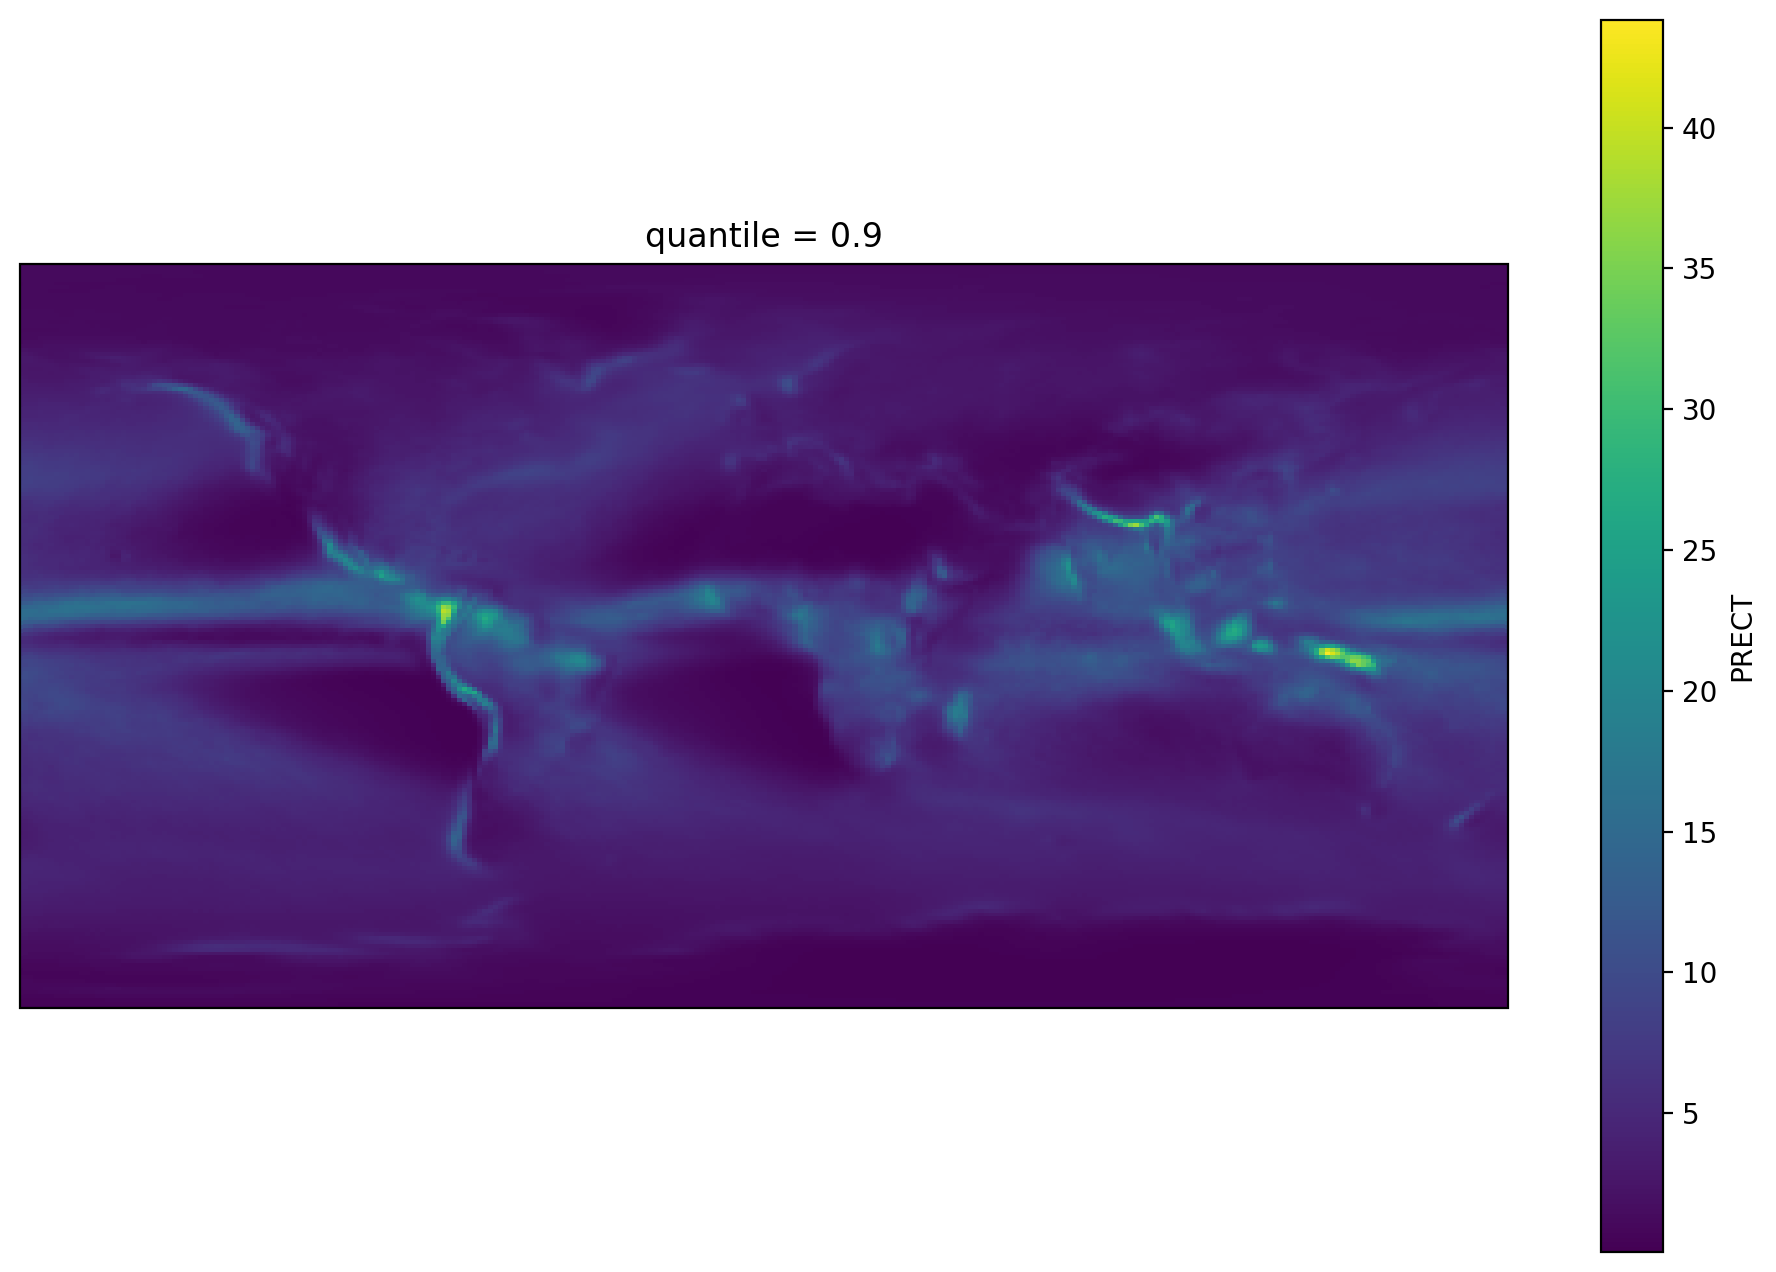

In [22]:
prect_cppe_q90['PRECT'].mean(dim='ensemble').plot(figsize = (12,8),subplot_kws={'projection': ccrs.PlateCarree()})

In [23]:
prect_mean_diff = prect_cppe_q90['PRECT'].mean(dim='ensemble') - prect_ppe_q90['PRECT'].mean(dim='ensemble')

In [24]:
prect_std_ratio = prect_cppe_q90['PRECT'].std(dim='ensemble') / prect_ppe_q90['PRECT'].std(dim='ensemble') 

In [25]:
prect_std_ratio

<xarray.DataArray 'PRECT' (lat: 192, lon: 288)> Size: 442kB
array([[0.97537729, 0.97537652, 0.97537629, ..., 0.97537846, 0.97537661,
        0.97537603],
       [1.03726249, 1.0493652 , 1.05415559, ..., 1.01217896, 1.01325039,
        1.01841081],
       [0.90912802, 0.90730122, 0.89854469, ..., 0.95200794, 0.93836701,
        0.92395229],
       ...,
       [0.90310977, 0.89169826, 0.88602662, ..., 0.90518698, 0.9034547 ,
        0.90959401],
       [0.7459035 , 0.73678302, 0.72891201, ..., 0.76766315, 0.75997152,
        0.7510144 ],
       [0.89257592, 0.89273141, 0.89277932, ..., 0.8924829 , 0.89240996,
        0.89278963]])
Coordinates:
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    quantile  float64 8B 0.9

In [26]:
prect_std_mean_diff = prect_mean_diff / prect_cppe_q90['PRECT'].mean(dim='ensemble')

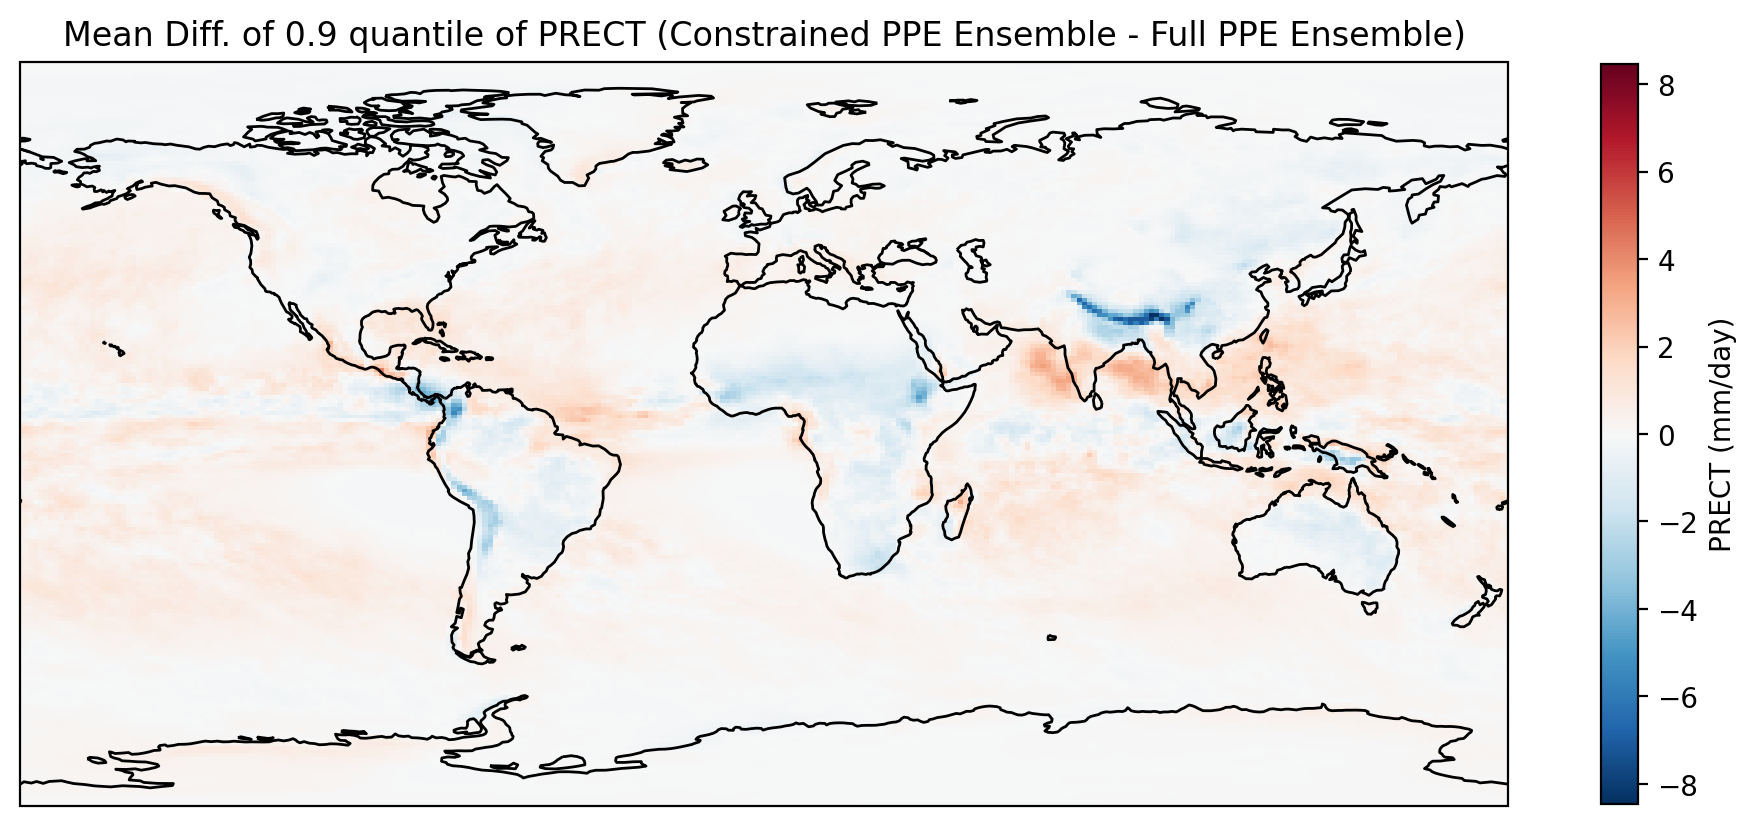

In [27]:
prect_mean_diff_plot = prect_mean_diff.plot(figsize=(12,8),
                                            subplot_kws={'projection': ccrs.PlateCarree()},
                                            cbar_kwargs={'shrink': 0.6,
                                                        'label': 'PRECT (mm/day)'})
plt.title('Mean Diff. of 0.9 quantile of PRECT (Constrained PPE Ensemble - Full PPE Ensemble)')
prect_mean_diff_plot.axes.coastlines();

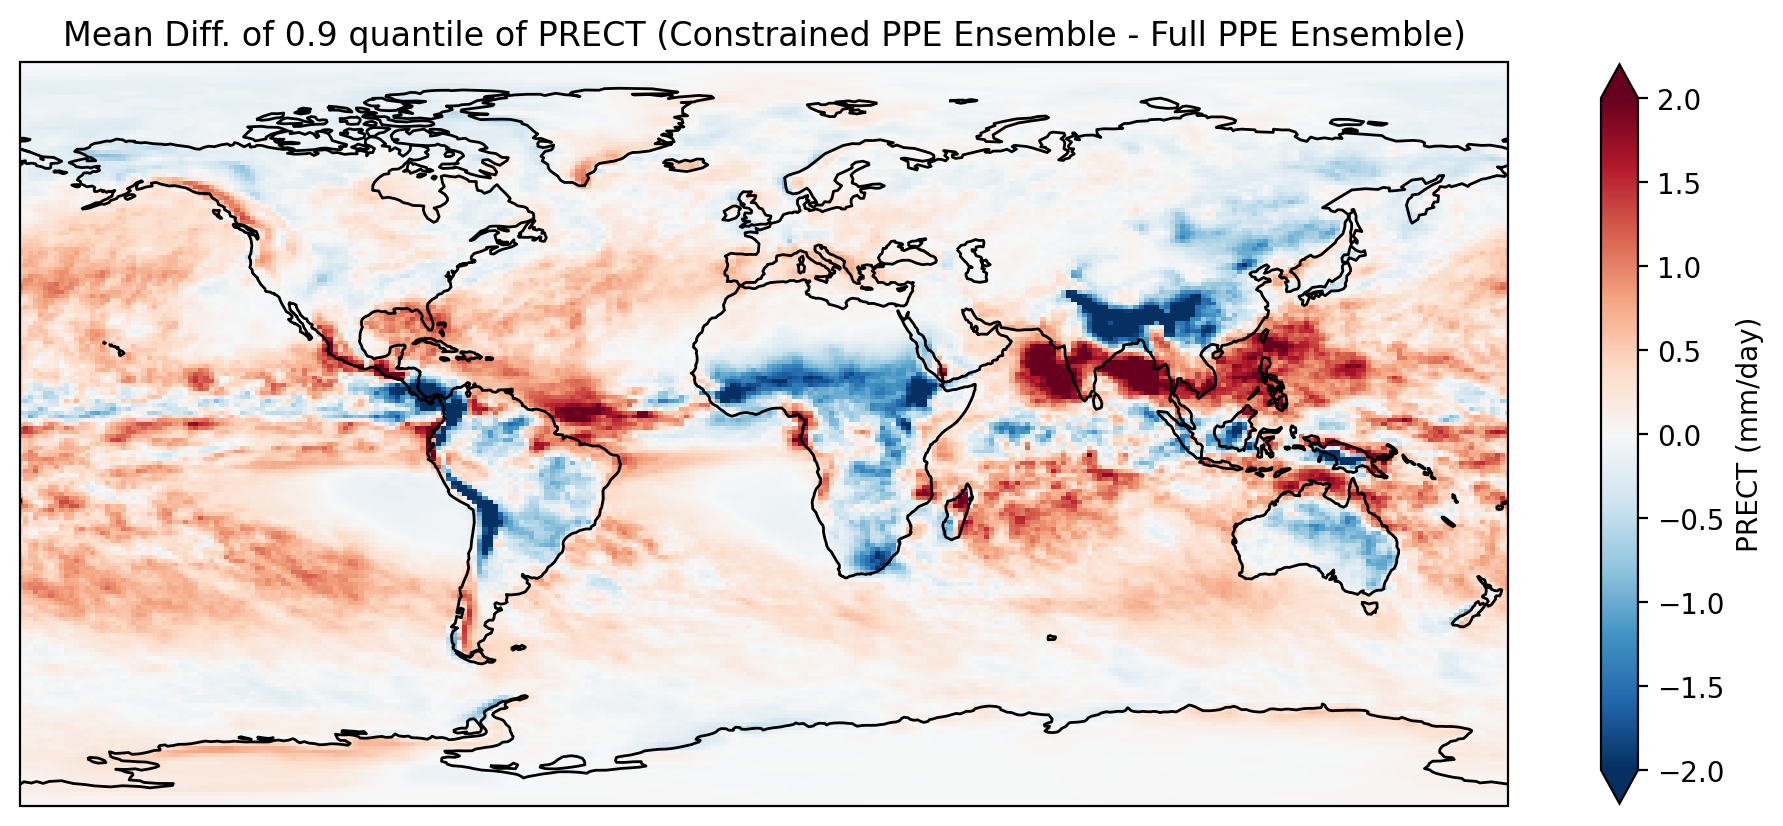

In [28]:
prect_mean_diff_plot_trunc = prect_mean_diff.plot(figsize=(12,8),
                                            vmin = -2,
                                            vmax = 2,
                                            cmap = 'RdBu_r',
                                            subplot_kws={'projection': ccrs.PlateCarree()},
                                            cbar_kwargs={'shrink': 0.6,
                                                        'label': 'PRECT (mm/day)'})
plt.title('Mean Diff. of 0.9 quantile of PRECT (Constrained PPE Ensemble - Full PPE Ensemble)')
prect_mean_diff_plot_trunc.axes.coastlines();

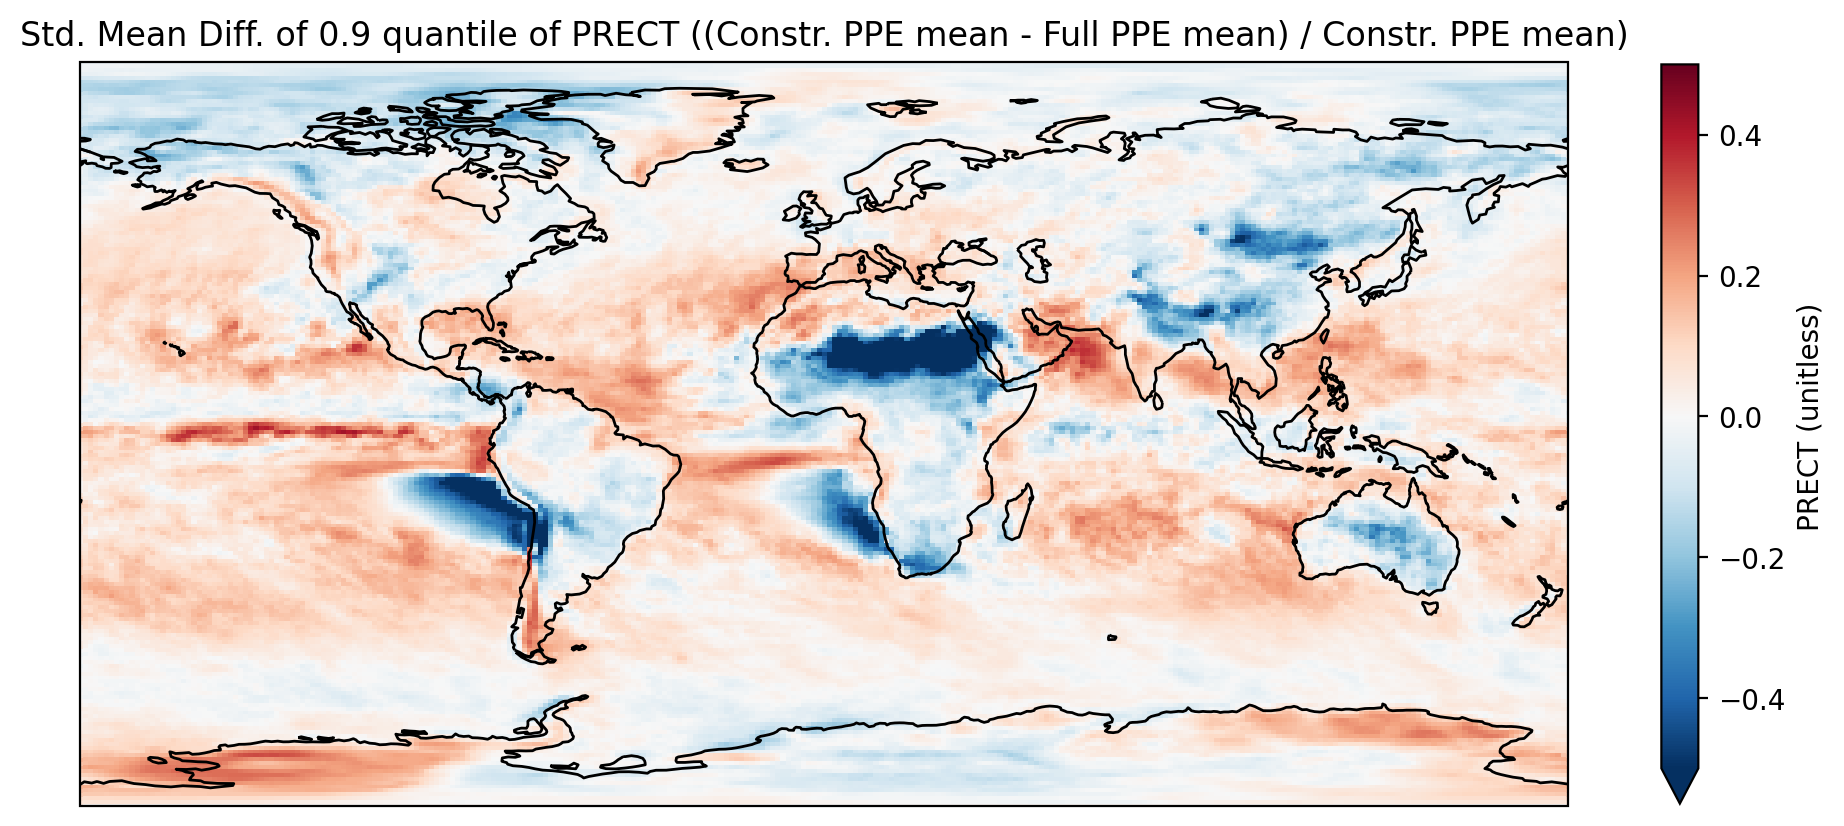

In [29]:
prect_std_mean_diff_plot = prect_std_mean_diff.plot(figsize=(12,8),
                                                    vmin = -0.5,
                                                    vmax = 0.5,
                                                    cmap = 'RdBu_r',
                                                    subplot_kws={'projection': ccrs.PlateCarree()},
                                                    cbar_kwargs={'shrink': 0.6,
                                                                 'label': 'PRECT (unitless)'})
plt.title('Std. Mean Diff. of 0.9 quantile of PRECT ((Constr. PPE mean - Full PPE mean) / Constr. PPE mean)')
prect_std_mean_diff_plot.axes.coastlines();

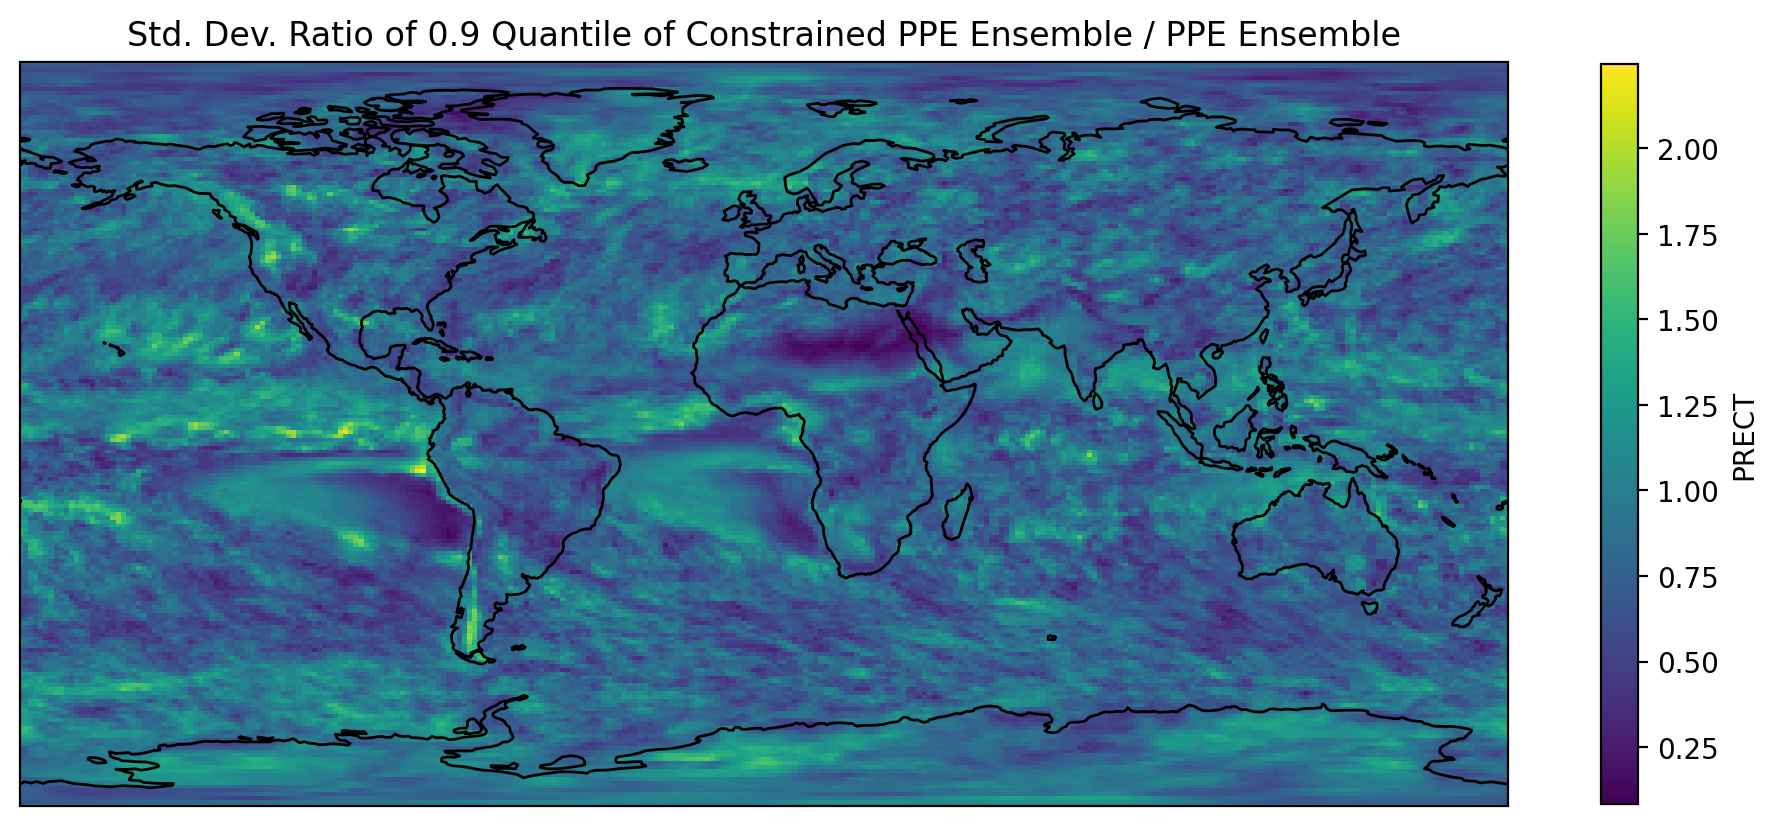

In [30]:
prect_std_ratio_plot = prect_std_ratio.plot(figsize=(12, 8),
                                            subplot_kws={'projection': ccrs.PlateCarree()},
                                           cbar_kwargs={'shrink': 0.6})
plt.title('Std. Dev. Ratio of 0.9 Quantile of Constrained PPE Ensemble / PPE Ensemble');
prect_std_ratio_plot.axes.coastlines();

In [69]:
cppe_amip_mean_diff = prect_cppe_q90['PRECT'].mean('ensemble') - amip_p90['PREC'].mean('ensemble')

In [31]:
cppe_amip_std_ratio = prect_cppe_q90['PRECT'].std('ensemble') / amip_p90['PREC'].std('ensemble')

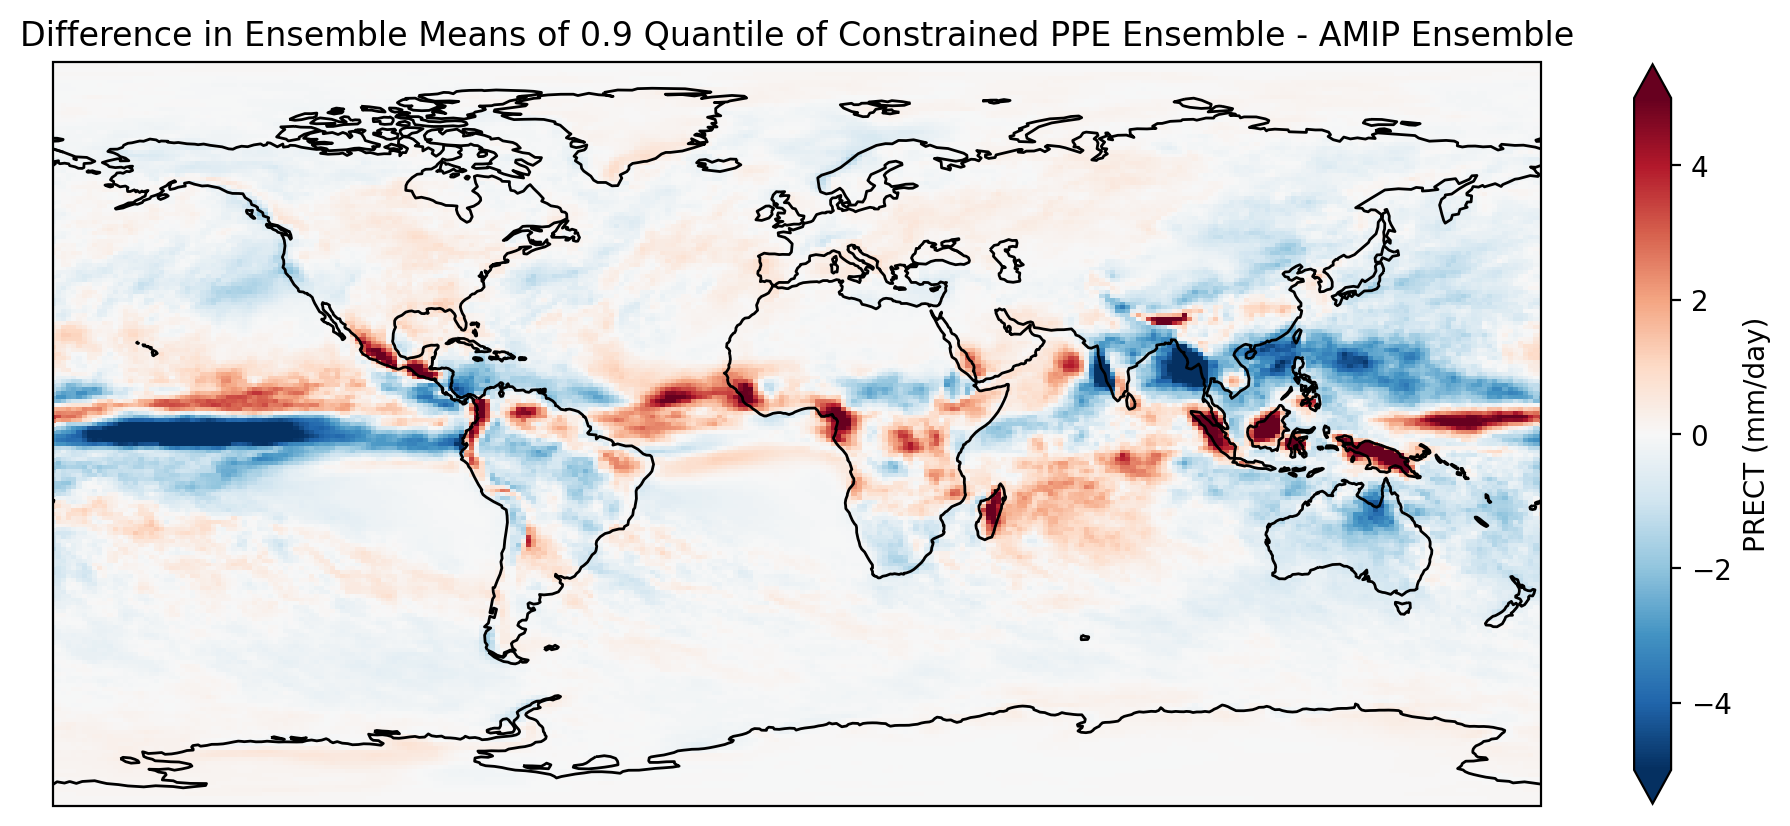

In [77]:
cppe_amip_mean_diff_plot = cppe_amip_mean_diff.plot(figsize=(12, 8),
                                                    vmin = -5,
                                                    vmax = 5,
                                                    cmap = 'RdBu_r',
                                            subplot_kws={'projection': ccrs.PlateCarree()},
                                           cbar_kwargs={'shrink': 0.6,
                                                       'label': 'PRECT (mm/day)'})
plt.title('Difference in Ensemble Means of 0.9 Quantile of Constrained PPE Ensemble - AMIP Ensemble');
cppe_amip_mean_diff_plot.axes.coastlines();
plt.savefig('images/cppe_amip_ensemble_mean_diff.png')

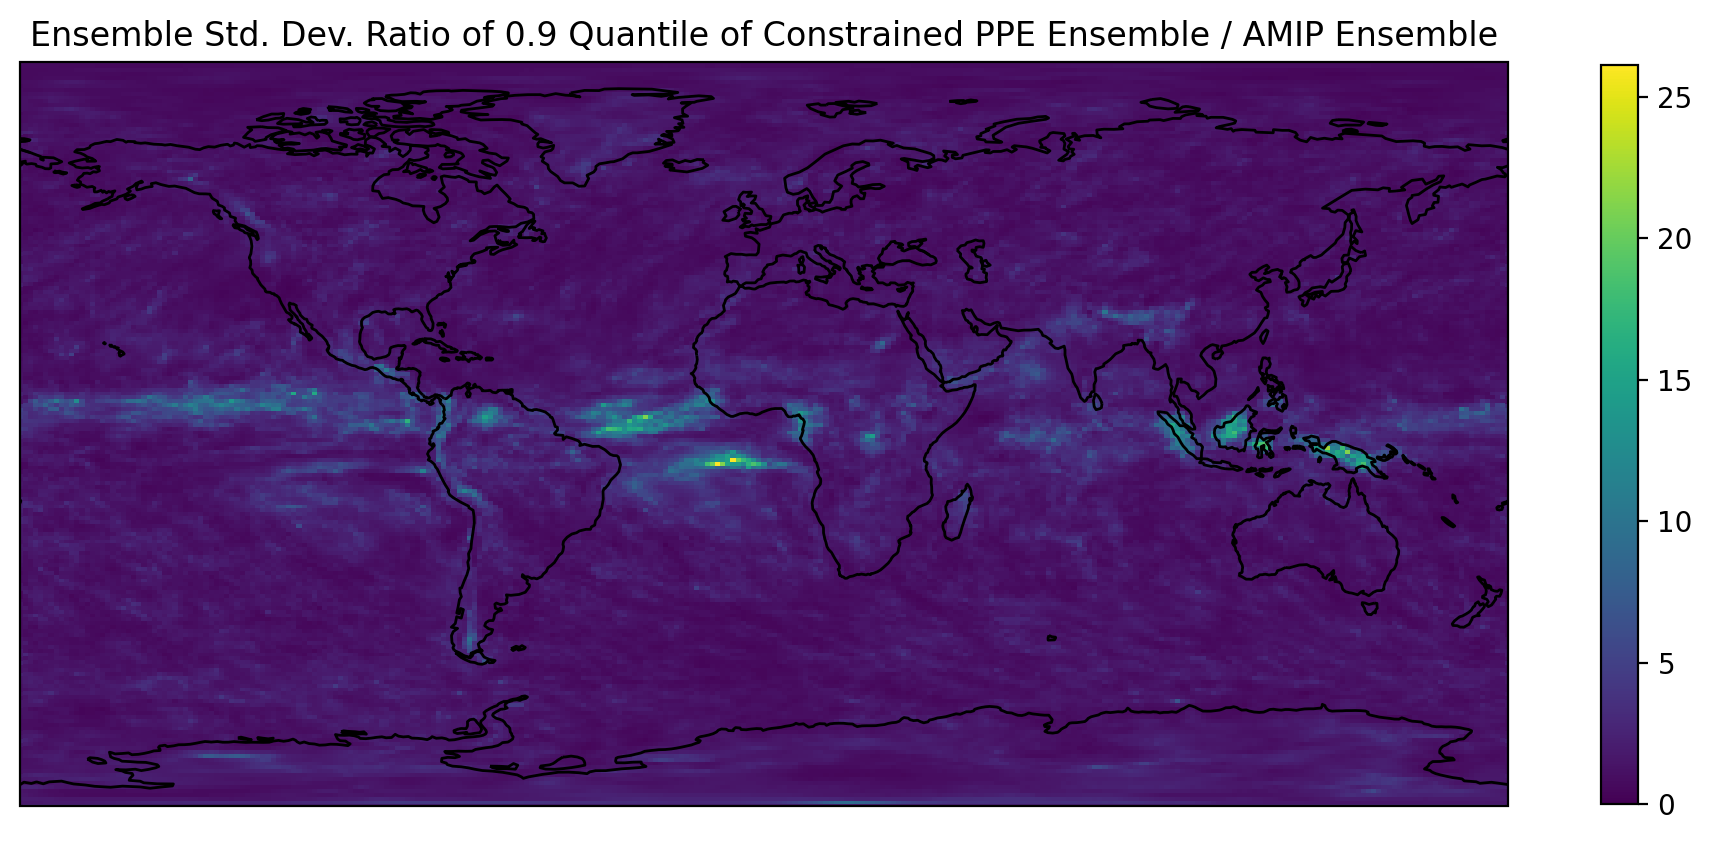

In [32]:
cppe_amip_std_ratio_plot = cppe_amip_std_ratio.plot(figsize=(12, 8),
                                                    vmin = 0,
                                            subplot_kws={'projection': ccrs.PlateCarree()},
                                           cbar_kwargs={'shrink': 0.6})
plt.title('Ensemble Std. Dev. Ratio of 0.9 Quantile of Constrained PPE Ensemble / AMIP Ensemble');
cppe_amip_std_ratio_plot.axes.coastlines();

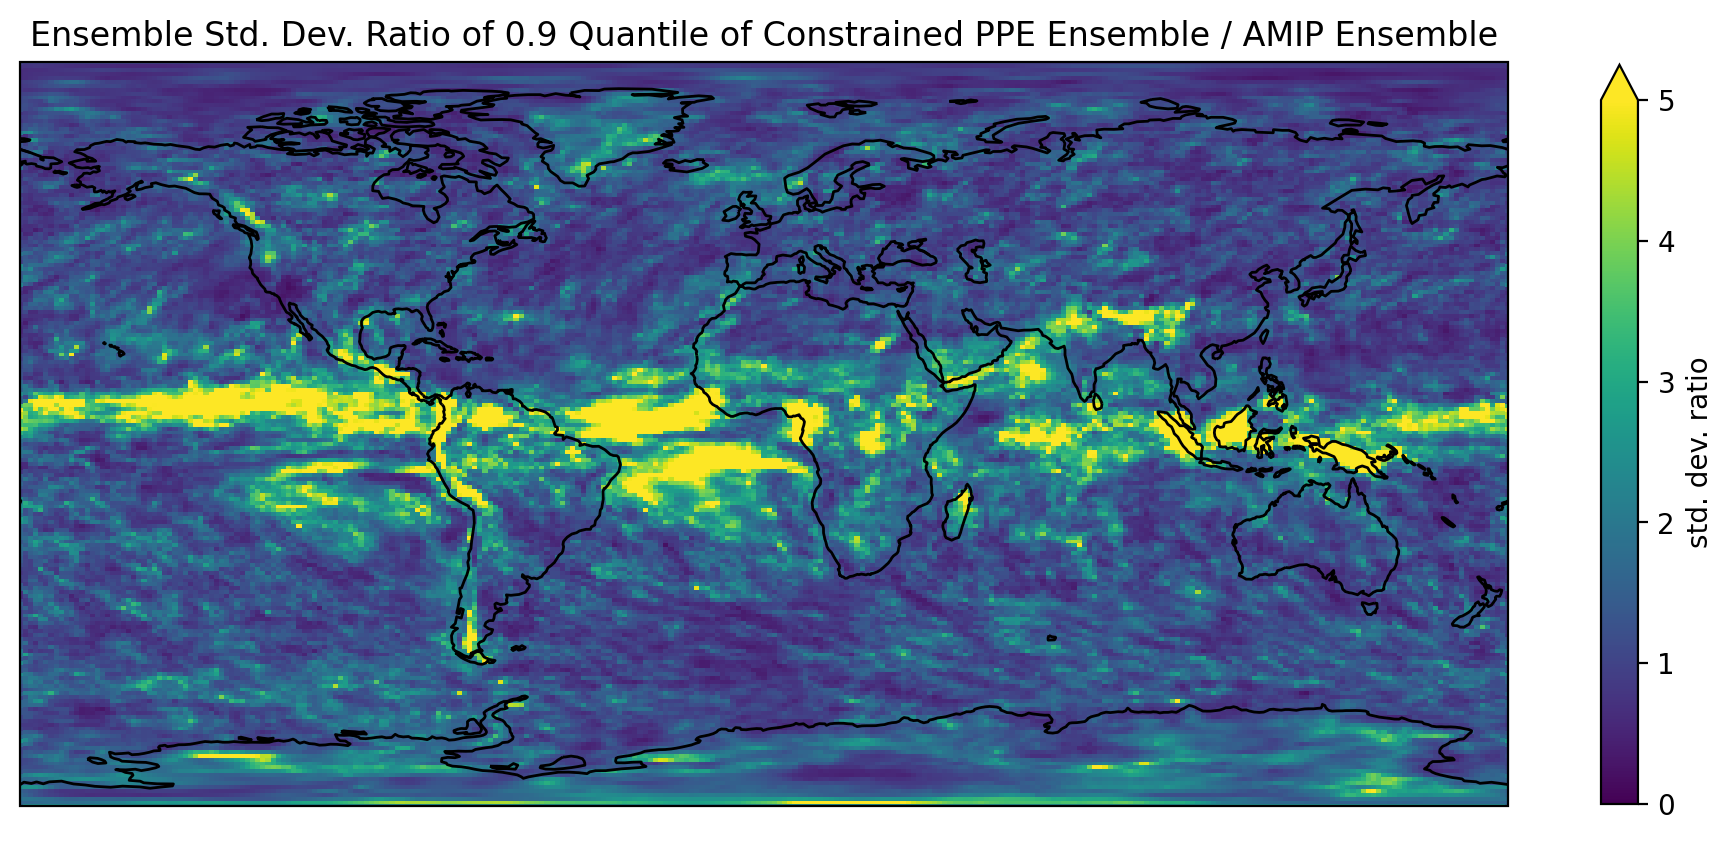

In [68]:
cppe_amip_std_ratio_plot_c = cppe_amip_std_ratio.plot(figsize=(12, 8),
                                                    vmin=0,
                                                    vmax = 5,
                                                    subplot_kws={'projection': ccrs.PlateCarree()},
                                                    cbar_kwargs={'label': 'std. dev. ratio',
                                                                 'shrink': 0.6})
plt.title('Ensemble Std. Dev. Ratio of 0.9 Quantile of Constrained PPE Ensemble / AMIP Ensemble');
cppe_amip_std_ratio_plot_c.axes.coastlines()
plt.savefig('images/constrained_ppe_vs_amip_quantile_variability.png');

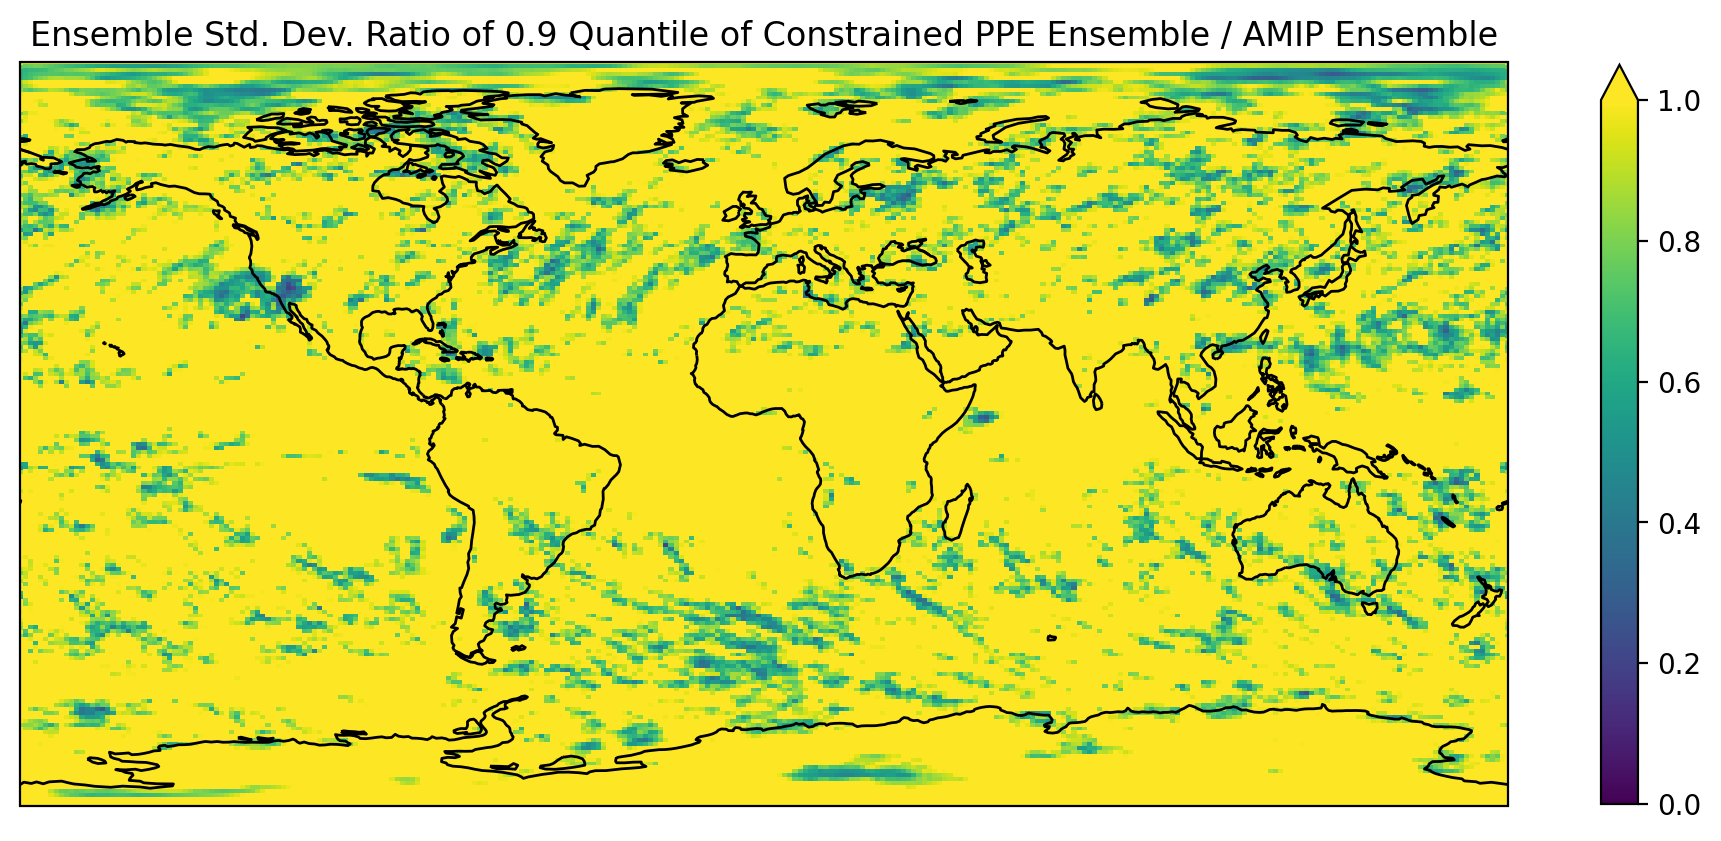

In [30]:
cppe_amip_std_ratio_plot_01 = cppe_amip_std_ratio.plot(figsize=(12, 8),
                                                    vmin=0,
                                                    vmax = 1,
                                                    subplot_kws={'projection': ccrs.PlateCarree()},
                                                    cbar_kwargs={'shrink': 0.6})
plt.title('Ensemble Std. Dev. Ratio of 0.9 Quantile of Constrained PPE Ensemble / AMIP Ensemble');
cppe_amip_std_ratio_plot_01.axes.coastlines();

In [26]:
prect_cppe_q90['PRECT'].values

array([[[0.31299686, 0.31299686, 0.31299686, ..., 0.31299683,
         0.31299685, 0.31299685],
        [0.32017477, 0.31551321, 0.31617603, ..., 0.32544217,
         0.32275492, 0.32299674],
        [0.22109674, 0.21872887, 0.21784876, ..., 0.22584691,
         0.2245637 , 0.22325176],
        ...,
        [1.01372865, 1.02093628, 1.02647418, ..., 1.00133145,
         1.00556776, 1.00825167],
        [1.14481932, 1.14150339, 1.13594222, ..., 1.15078694,
         1.14972472, 1.1477288 ],
        [1.00748354, 1.00747612, 1.00747052, ..., 1.00748816,
         1.00748467, 1.00748545]],

       [[0.35669954, 0.35669954, 0.35669954, ..., 0.35669954,
         0.35669954, 0.35669954],
        [0.34778526, 0.34649755, 0.34456167, ..., 0.35166466,
         0.35030021, 0.34917395],
        [0.28227772, 0.28057864, 0.27924643, ..., 0.30193454,
         0.29537603, 0.28784879],
        ...,
        [1.21708739, 1.21445256, 1.21999568, ..., 1.27966326,
         1.24574262, 1.22871518],
        [1.1

In [36]:
ECDF?

Init signature: ECDF(x, side='right')
Docstring:     
Return the Empirical CDF of an array as a step function.

Parameters
----------
x : array_like
    Observations
side : {'left', 'right'}, optional
    Default is 'right'. Defines the shape of the intervals constituting the
    steps. 'right' correspond to [a, b) intervals and 'left' to (a, b].

Returns
-------
Empirical CDF as a step function.

Examples
--------
>>> import numpy as np
>>> from statsmodels.distributions.empirical_distribution import ECDF
>>>
>>> ecdf = ECDF([3, 3, 1, 4])
>>>
>>> ecdf([3, 55, 0.5, 1.5])
array([ 0.75,  1.  ,  0.  ,  0.25])
File:           /srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/distributions/empirical_distribution.py
Type:           type
Subclasses:     

In [41]:
amip_p90['PREC'].values[0].shape

(192, 288)

In [44]:
prect_cppe_q90['PRECT'].values.shape

(10, 192, 288)

In [46]:
amip_ecdfs = []
cppe_ecdfs = []
for i in range(10):
    amip_ecdfs.append(ECDF(np.ravel(amip_p90['PREC'].values[i])))
    cppe_ecdfs.append(ECDF(np.ravel(prect_cppe_q90['PRECT'].values[i])))

In [27]:
amip_ecdf = ECDF(np.ravel(amip_p90['PREC'].values))
cppe_ecdf = ECDF(np.ravel(prect_cppe_q90['PRECT'].values))

In [78]:
np.max(amip_p90['PREC'].values)

39.77292442321777

In [90]:
np.max(prect_cppe_q90['PRECT'].values[9])

29.446548461914062

In [47]:
max_val = np.max([np.max(amip_p90['PREC'].values), np.max(prect_cppe_q90['PRECT'].values)])
min_val = np.min([np.min(amip_p90['PREC'].values), np.min(prect_cppe_q90['PRECT'].values)])
x = np.linspace(min_val, max_val, 1000)
amip_ecdf_vals_list = []
cppe_ecdf_vals_list = []
for i in range(10):
    amip_ecdf_vals_list.append(amip_ecdfs[i](x))
    cppe_ecdf_vals_list.append(cppe_ecdfs[i](x))

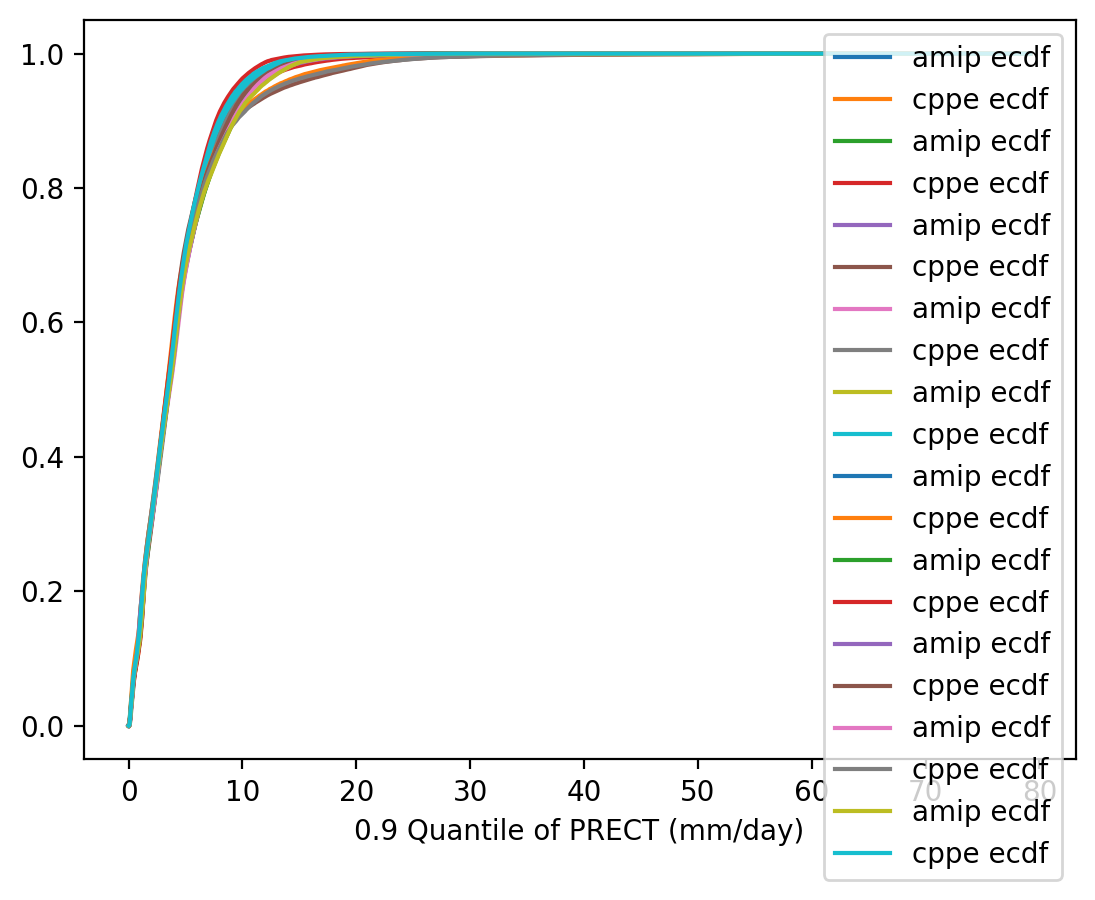

In [48]:
for i in range(10):
    plt.plot(x, amip_ecdf_vals_list[i], label='amip ecdf')
    plt.plot(x, cppe_ecdf_vals_list[i], label='cppe ecdf')
    plt.xlabel('0.9 Quantile of PRECT (mm/day)')
    plt.legend()

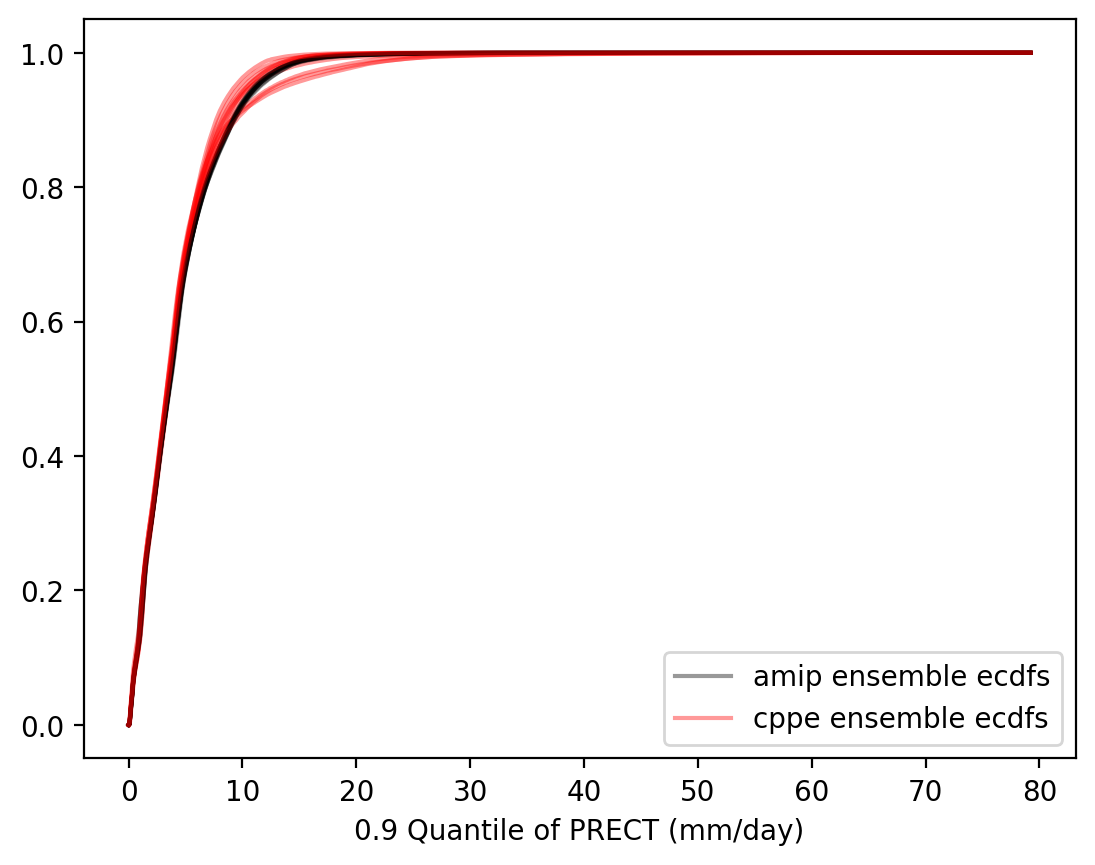

In [67]:
for i in range(10):
    if i == 0:
        plt.plot(x, amip_ecdf_vals_list[i], label='amip ensemble ecdfs', color='k', alpha = 0.4)
        plt.plot(x, cppe_ecdf_vals_list[i], label='cppe ensemble ecdfs', color='red', alpha = 0.4)
        plt.xlabel('0.9 Quantile of PRECT (mm/day)')
        plt.legend()
    else:
        plt.plot(x, amip_ecdf_vals_list[i], color='k', alpha=0.4)
        plt.plot(x, cppe_ecdf_vals_list[i], color='red', alpha=0.4)
        plt.xlabel('0.9 Quantile of PRECT (mm/day)')
        plt.legend()
plt.savefig('images/ecdf_comp_zoom_out.png')

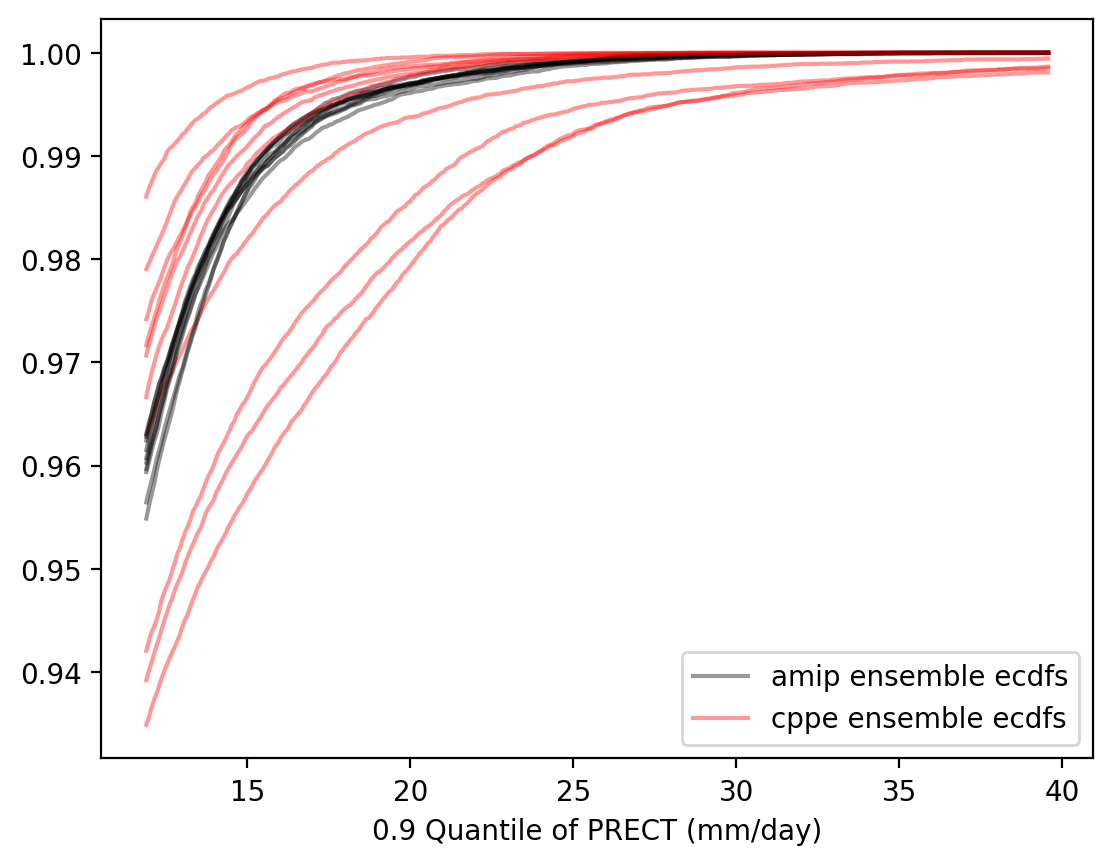

In [57]:
for i in range(10):
    if i == 0:
        plt.plot(x[150:500], amip_ecdf_vals_list[i][150:500], label='amip ensemble ecdfs', color='k', alpha = 0.4)
        plt.plot(x[150:500], cppe_ecdf_vals_list[i][150:500], label='cppe ensemble ecdfs', color='red', alpha = 0.4)
        plt.xlabel('0.9 Quantile of PRECT (mm/day)')
        plt.legend()
    else:
        plt.plot(x[150:500], amip_ecdf_vals_list[i][150:500], color='k', alpha=0.4)
        plt.plot(x[150:500], cppe_ecdf_vals_list[i][150:500], color='red', alpha=0.4)
        plt.xlabel('0.9 Quantile of PRECT (mm/day)')
        plt.legend()

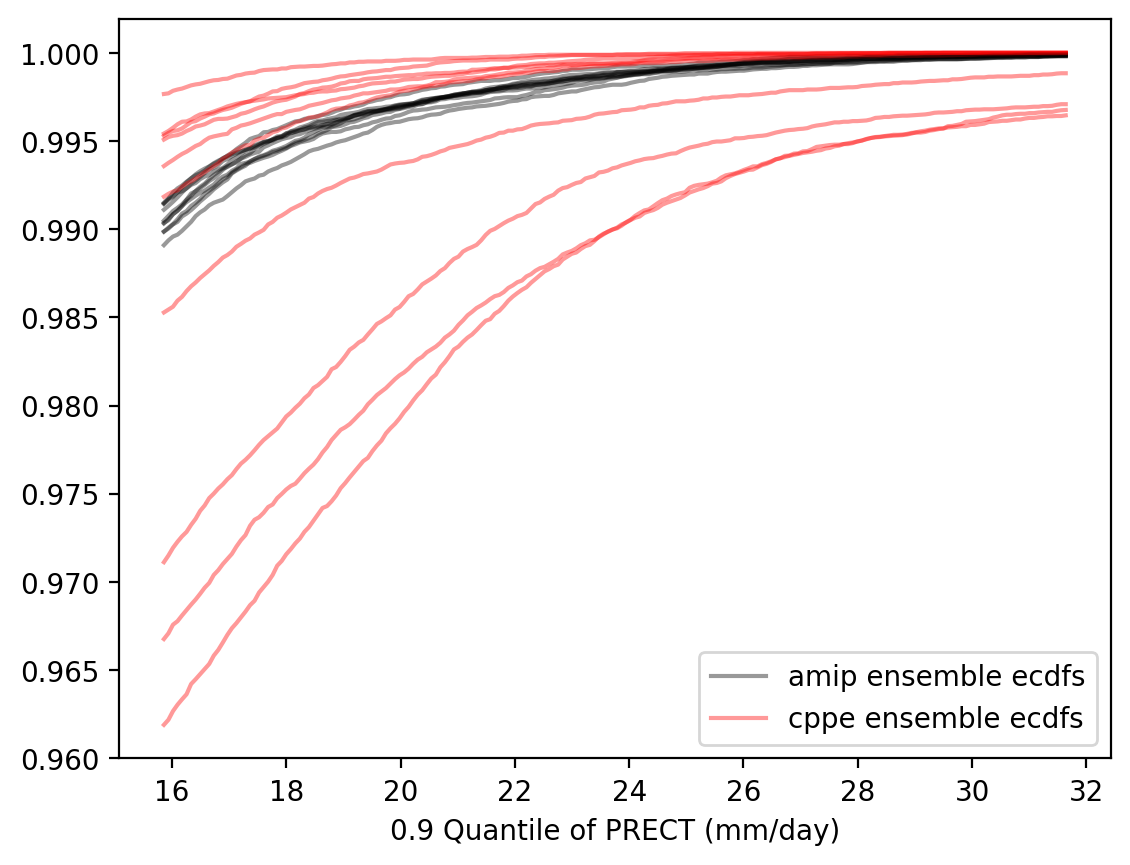

In [64]:
for i in range(10):
    if i == 0:
        plt.plot(x[200:400], amip_ecdf_vals_list[i][200:400], label='amip ensemble ecdfs', color='k', alpha = 0.4)
        plt.plot(x[200:400], cppe_ecdf_vals_list[i][200:400], label='cppe ensemble ecdfs', color='red', alpha = 0.4)
        plt.xlabel('0.9 Quantile of PRECT (mm/day)')
        plt.legend()
    else:
        plt.plot(x[200:400], amip_ecdf_vals_list[i][200:400], color='k', alpha=0.4)
        plt.plot(x[200:400], cppe_ecdf_vals_list[i][200:400], color='red', alpha=0.4)
        plt.xlabel('0.9 Quantile of PRECT (mm/day)')
        plt.legend()
plt.savefig('images/ecdf_comp.png')

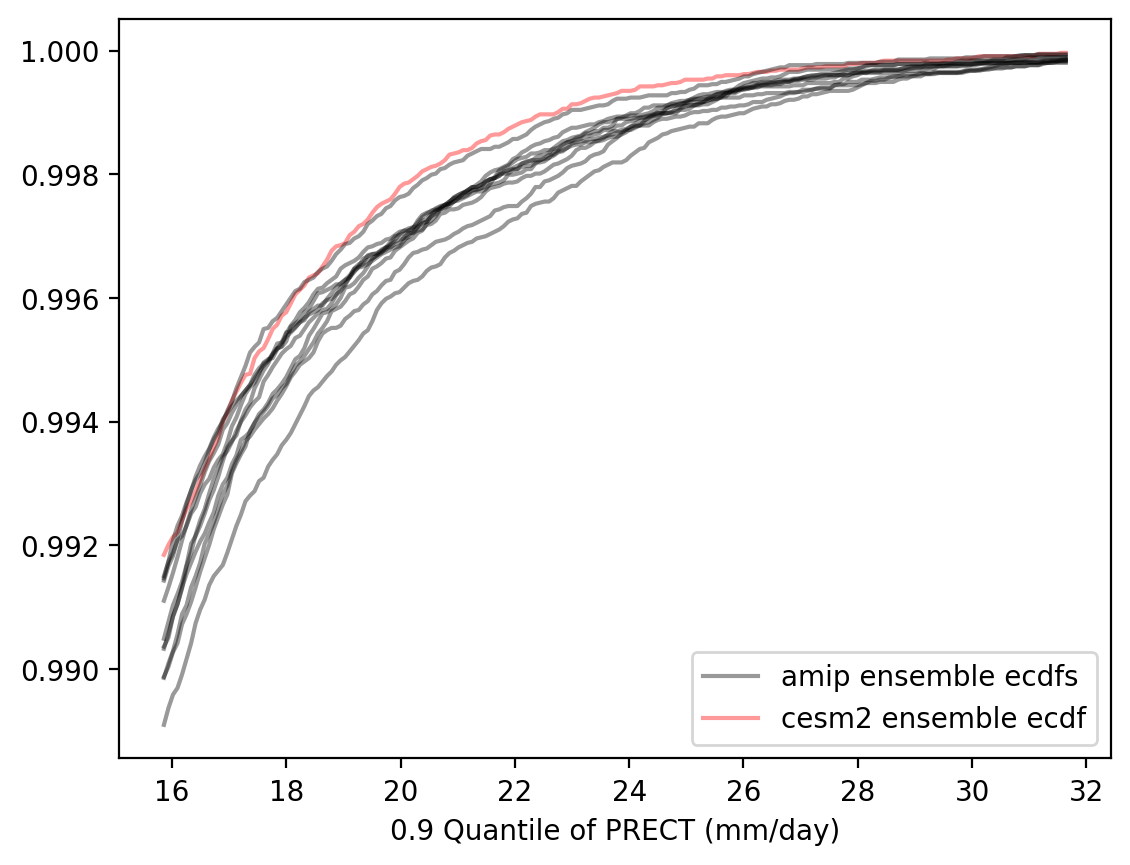

In [63]:
for i in range(10):
    if i == 0:
        plt.plot(x[200:400], amip_ecdf_vals_list[i][200:400], label='amip ensemble ecdfs', color='k', alpha = 0.4)
        plt.plot(x[200:400], cppe_ecdf_vals_list[7][200:400], label='cesm2 ensemble ecdf', color='red', alpha = 0.4)
        plt.xlabel('0.9 Quantile of PRECT (mm/day)')
        plt.legend()
    else:
        plt.plot(x[200:400], amip_ecdf_vals_list[i][200:400], color='k', alpha=0.4)
        plt.xlabel('0.9 Quantile of PRECT (mm/day)')
        plt.legend()

In [61]:
prect_cppe_q90['PRECT'].size

552960

In [62]:
552960 / 10 * (1 - 0.999)

55.29600000000005

In [31]:
lat_bins = np.arange(-90, 91, 20)

In [41]:
amip_p90['weights'] = np.cos(np.radians(amip_p90['lat']))

In [43]:
amip_p90

<xarray.Dataset> Size: 4MB
Dimensions:   (lat: 192, lon: 288, ensemble: 10)
Coordinates:
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * ensemble  (ensemble) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    PREC      (ensemble, lat, lon) float64 4MB 0.3229 0.3229 ... 1.364 1.364
    weights   (lat) float64 2kB 6.123e-17 0.01645 0.03289 ... 0.01645 6.123e-17

In [67]:
weighted_amip = amip_p90['weights'] * amip_p90['PREC']

In [70]:
binned_mean2 = weighted_amip.groupby_bins('lat', lat_bins).mean(dim=('lat', 'lon'))

In [71]:
binned_mean2

<xarray.DataArray (lat_bins: 9, ensemble: 10)> Size: 720B
array([[0.21517806, 0.21146444, 0.21283419, 0.21295799, 0.21934707,
        0.21991128, 0.21574297, 0.21834802, 0.22248858, 0.22297359],
       [1.79671256, 1.80179734, 1.81723321, 1.79211795, 1.80888958,
        1.78940319, 1.7867882 , 1.79416199, 1.80221247, 1.82236555],
       [3.52770129, 3.45475397, 3.48238293, 3.55238992, 3.47800593,
        3.47054189, 3.45698871, 3.50263447, 3.56584504, 3.47446573],
       [4.76273855, 4.84506399, 4.8967989 , 4.82008187, 4.68127158,
        4.77150999, 4.88777658, 4.91240844, 4.80579488, 4.9741512 ],
       [8.95111368, 9.13256221, 8.87178145, 9.01252777, 9.06933193,
        9.11572653, 8.91393813, 8.88020475, 8.95938741, 8.98150587],
       [5.76841681, 5.52865274, 5.79874444, 5.94871829, 5.59653083,
        5.51496865, 5.63536271, 5.67826884, 5.57888358, 5.73557185],
       [3.54213455, 3.49164751, 3.47884241, 3.48791518, 3.47594841,
        3.53431078, 3.50055181, 3.45221092, 3.46559605, 3.5184063 ],
       [1.76161452, 1.79997169, 1.79511484, 1.80535503, 1.81345582,
        1.7841912 , 1.78606019, 1.82591621, 1.79410688, 1.79663936],
       [0.28442953, 0.29786616, 0.29598968, 0.28042061, 0.28042925,
        0.28366032, 0.30494762, 0.28533479, 0.29964141, 0.29375656]])
Coordinates:
  * ensemble  (ensemble) int64 80B 0 1 2 3 4 5 6 7 8 9
  * lat_bins  (lat_bins) object 72B (-90, -70] (-70, -50] ... (50, 70] (70, 90]

In [82]:
amip_grouped = amip_p90['PREC'].groupby_bins('lat', lat_bins)

In [83]:
binned_mean = amip_grouped.mean(dim=('lat', 'lon'))

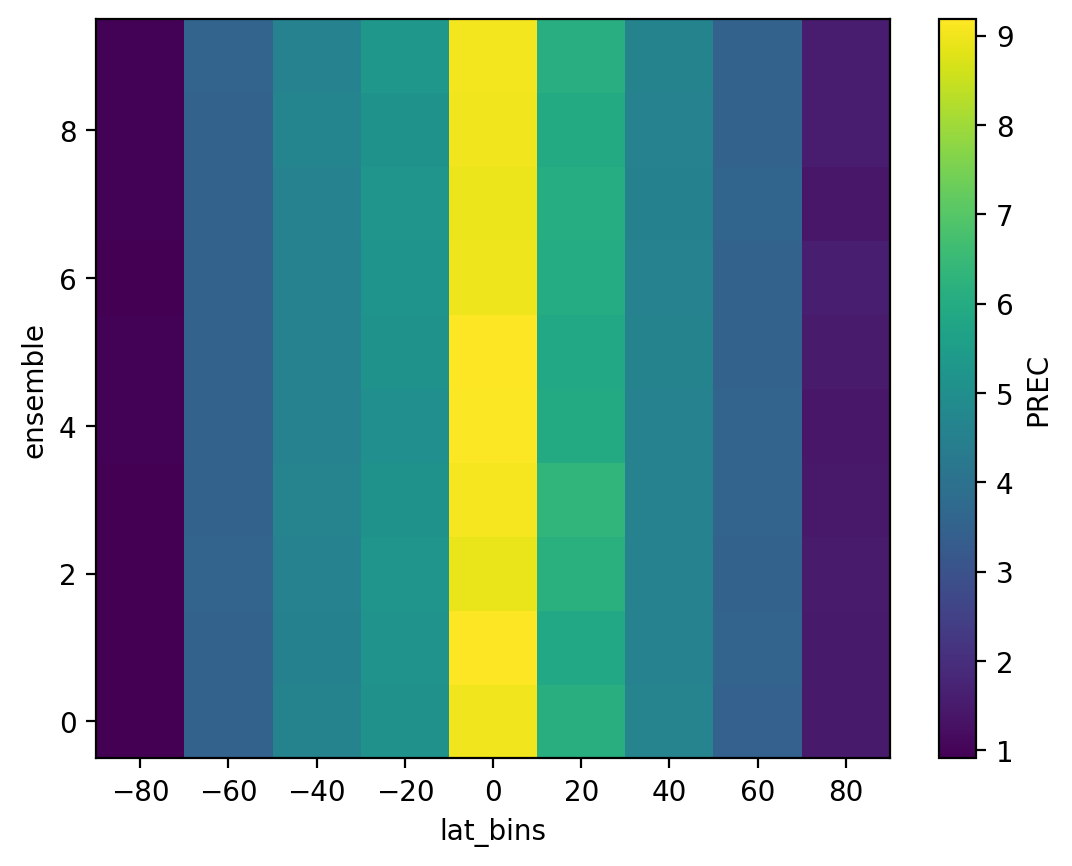

In [85]:
binned_mean.plot()

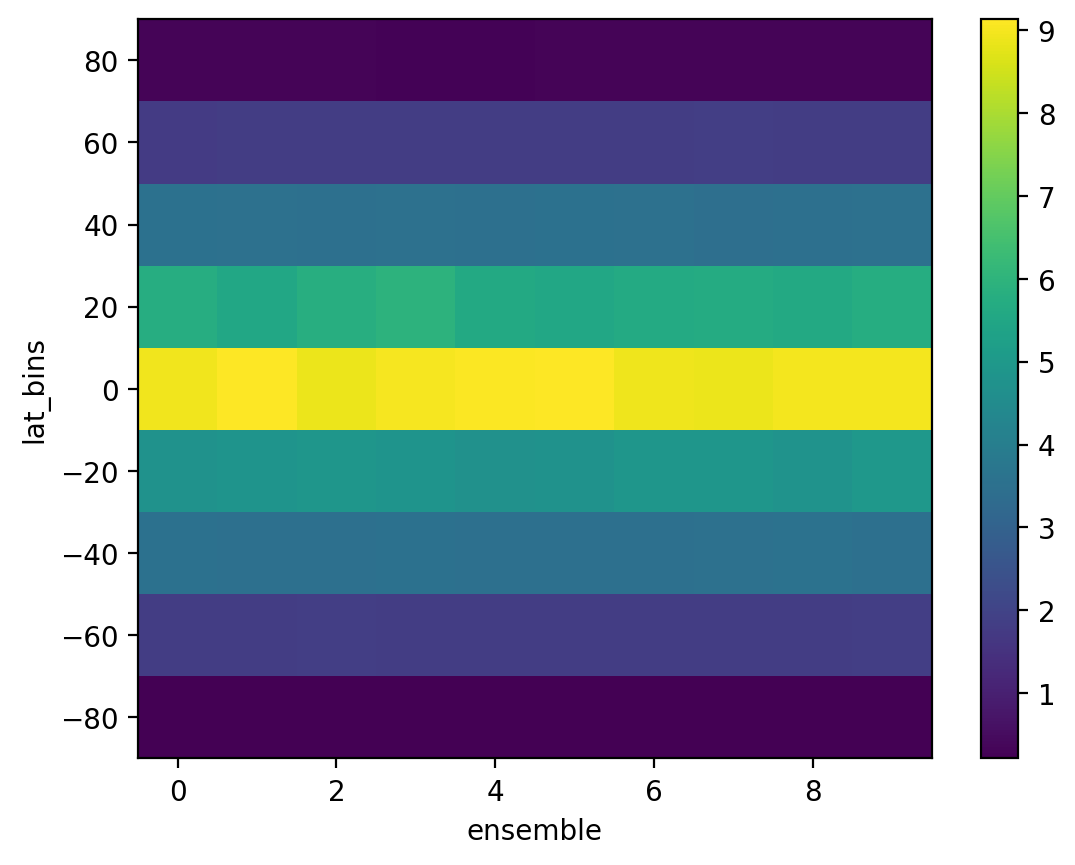

In [73]:
binned_mean2.plot()

In [91]:
prect_ppe_q90['weights'] = np.cos(np.radians(prect_ppe_q90w.lat))

In [94]:
prect_ppe_q90

<xarray.Dataset> Size: 116MB
Dimensions:   (ensemble: 262, lat: 192, lon: 288)
Coordinates:
  * ensemble  (ensemble) int64 2kB 0 1 2 3 4 5 6 ... 256 257 258 259 260 261 262
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    quantile  float64 8B ...
Data variables:
    PRECT     (ensemble, lat, lon) float64 116MB 0.3947 0.3947 ... 1.024 1.024
    weights   (lat) float64 2kB 6.123e-17 0.01645 0.03289 ... 0.01645 6.123e-17

In [95]:
prect_ppe_weighted = prect_ppe_q90['PRECT'] * prect_ppe_q90['weights']

In [96]:
prect_ppe_weighted

<xarray.DataArray (ensemble: 262, lat: 192, lon: 288)> Size: 116MB
array([[[2.41675637e-17, 2.41675637e-17, 2.41675637e-17, ...,
         2.41675637e-17, 2.41675637e-17, 2.41675637e-17],
        [6.38548533e-03, 6.37455527e-03, 6.36672725e-03, ...,
         6.43849897e-03, 6.41742483e-03, 6.40087545e-03],
        [1.04210709e-02, 1.02937860e-02, 1.02033789e-02, ...,
         1.08029904e-02, 1.06732446e-02, 1.05465723e-02],
        ...,
        [4.90891950e-02, 4.90176006e-02, 4.90018937e-02, ...,
         4.86413065e-02, 4.86130158e-02, 4.88486852e-02],
        [2.22007236e-02, 2.22141386e-02, 2.22250106e-02, ...,
         2.22060253e-02, 2.22075350e-02, 2.21812717e-02],
        [7.29808634e-17, 7.29784253e-17, 7.29775238e-17, ...,
         7.29844145e-17, 7.29802976e-17, 7.29815641e-17]],

       [[2.61851975e-17, 2.61851975e-17, 2.61851975e-17, ...,
         2.61851975e-17, 2.61851975e-17, 2.61851975e-17],
        [7.45874736e-03, 7.45103747e-03, 7.44019883e-03, ...,
         7.45195360e-03, 7.46182563e-03, 7.46565288e-03],
        [1.01990023e-02, 1.00964304e-02, 1.00172129e-02, ...,
         1.04429952e-02, 1.03728898e-02, 1.02824798e-02],
...
        [3.42895272e-02, 3.41943353e-02, 3.40717093e-02, ...,
         3.35764200e-02, 3.42599936e-02, 3.43638172e-02],
        [1.87179663e-02, 1.88729375e-02, 1.89754106e-02, ...,
         1.91046685e-02, 1.89694050e-02, 1.87919555e-02],
        [6.31437045e-17, 6.31447265e-17, 6.31447922e-17, ...,
         6.31432921e-17, 6.31434272e-17, 6.31432775e-17]],

       [[2.67215064e-17, 2.67215064e-17, 2.67215064e-17, ...,
         2.67215064e-17, 2.67215064e-17, 2.67215064e-17],
        [5.97679478e-03, 5.93361641e-03, 5.89543459e-03, ...,
         6.10308030e-03, 6.05998257e-03, 6.01770562e-03],
        [9.37570693e-03, 9.30937330e-03, 9.23374878e-03, ...,
         9.36215604e-03, 9.34382664e-03, 9.38191997e-03],
        ...,
        [3.99231987e-02, 4.00289278e-02, 3.99765141e-02, ...,
         3.94841046e-02, 3.96035371e-02, 3.98199984e-02],
        [2.03993525e-02, 2.05011109e-02, 2.05895249e-02, ...,
         2.00679513e-02, 2.02295840e-02, 2.03066721e-02],
        [6.26778199e-17, 6.26773454e-17, 6.26772323e-17, ...,
         6.26782652e-17, 6.26773564e-17, 6.26777615e-17]]])
Coordinates:
  * ensemble  (ensemble) int64 2kB 0 1 2 3 4 5 6 ... 256 257 258 259 260 261 262
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    quantile  float64 8B 0.9

In [97]:
ppe_grouped = prect_ppe_weighted.groupby_bins('lat', lat_bins)
ppe_binned_mean = ppe_grouped.mean(dim=('lat', 'lon'))

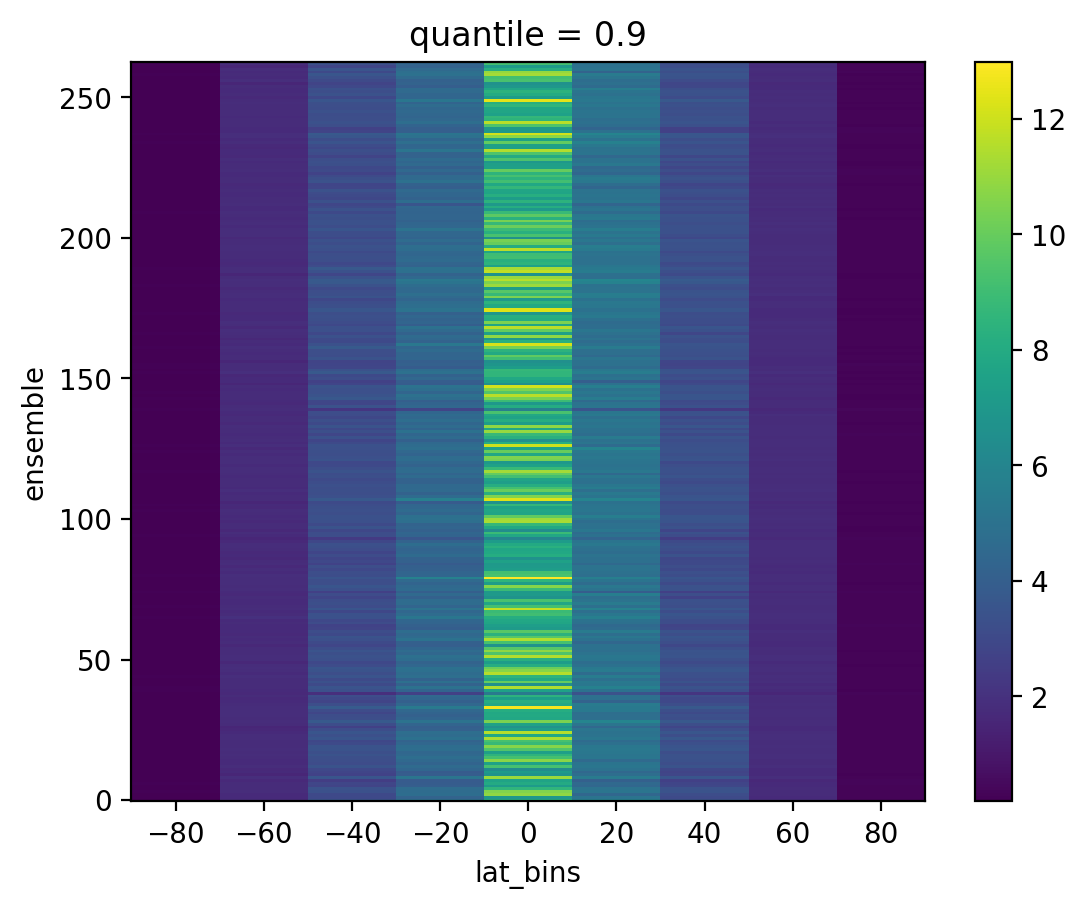

In [99]:
ppe_binned_mean.plot()

In [100]:
ppe_binned_mean

<xarray.DataArray (ensemble: 262, lat_bins: 9)> Size: 19kB
array([[0.22406355, 1.77890991, 3.47779925, ..., 3.34177047, 1.81897105,
        0.30075244],
       [0.2001243 , 1.69132793, 2.98381027, ..., 3.05270336, 1.72351611,
        0.28418863],
       [0.22796997, 1.70441685, 3.012371  , ..., 3.14455241, 1.74419745,
        0.30662066],
       ...,
       [0.22004022, 1.78284115, 3.52336052, ..., 3.44242627, 1.79316518,
        0.30212766],
       [0.19359611, 1.54845254, 2.82790543, ..., 3.16463663, 1.7009143 ,
        0.29398733],
       [0.26008668, 1.81389411, 3.31295938, ..., 3.19981592, 1.79591336,
        0.29544188]])
Coordinates:
  * ensemble  (ensemble) int64 2kB 0 1 2 3 4 5 6 ... 256 257 258 259 260 261 262
    quantile  float64 8B 0.9
  * lat_bins  (lat_bins) object 72B (-90, -70] (-70, -50] ... (50, 70] (70, 90]

In [43]:
cppe_grouped = prect_cppe_q90.groupby_bins('lat', lat_bins)
cppe_binned_mean = cppe_grouped.mean(dim=('lat', 'lon'))

In [46]:
cppe_binned_mean.sortby('ensemble')

<xarray.Dataset> Size: 880B
Dimensions:   (lat_bins: 9, ensemble: 10)
Coordinates:
  * ensemble  (ensemble) int64 80B 0 39 76 103 126 153 197 226 253 258
    quantile  float64 8B 0.9
  * lat_bins  (lat_bins) object 72B (-90, -70] (-70, -50] ... (50, 70] (70, 90]
Data variables:
    PRECT     (lat_bins, ensemble) float64 720B 0.9878 1.029 ... 1.441 1.446

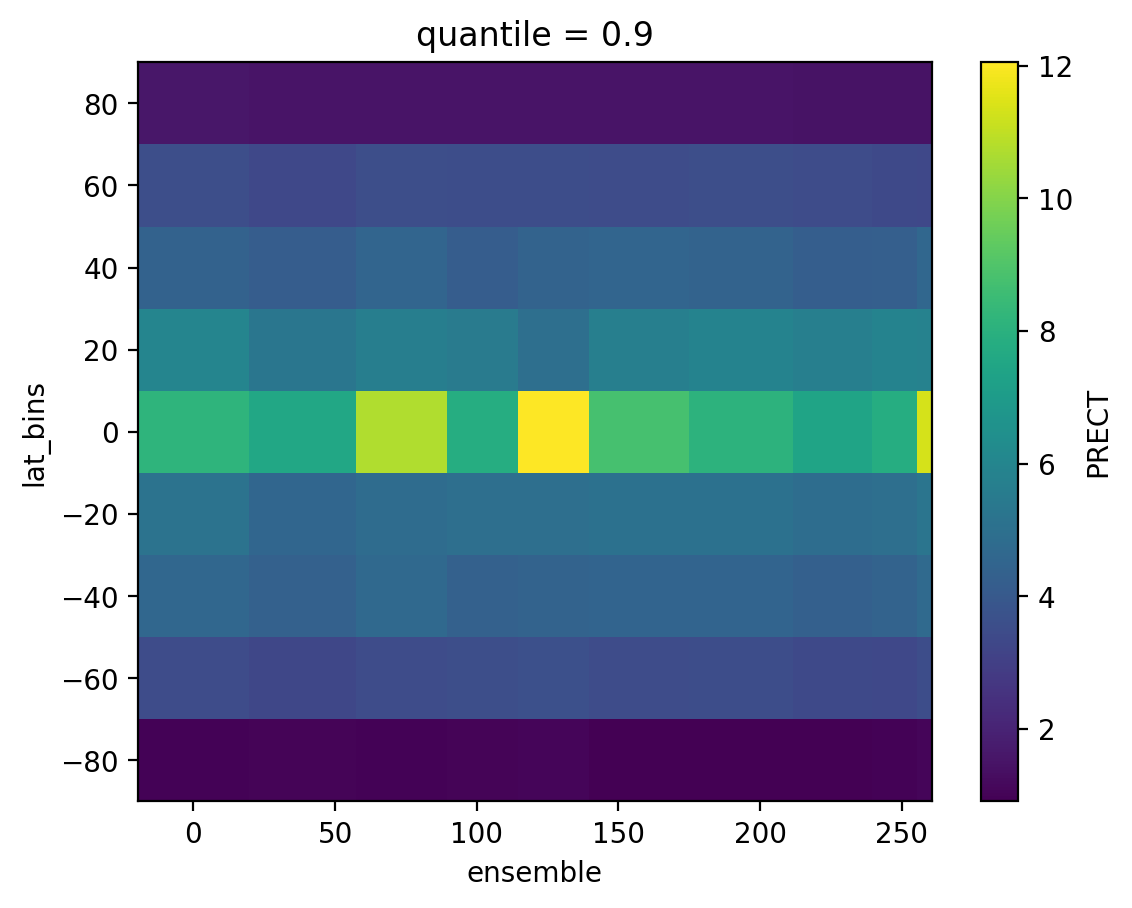

In [48]:
cppe_binned_mean['PRECT'].sortby('ensemble').plot()

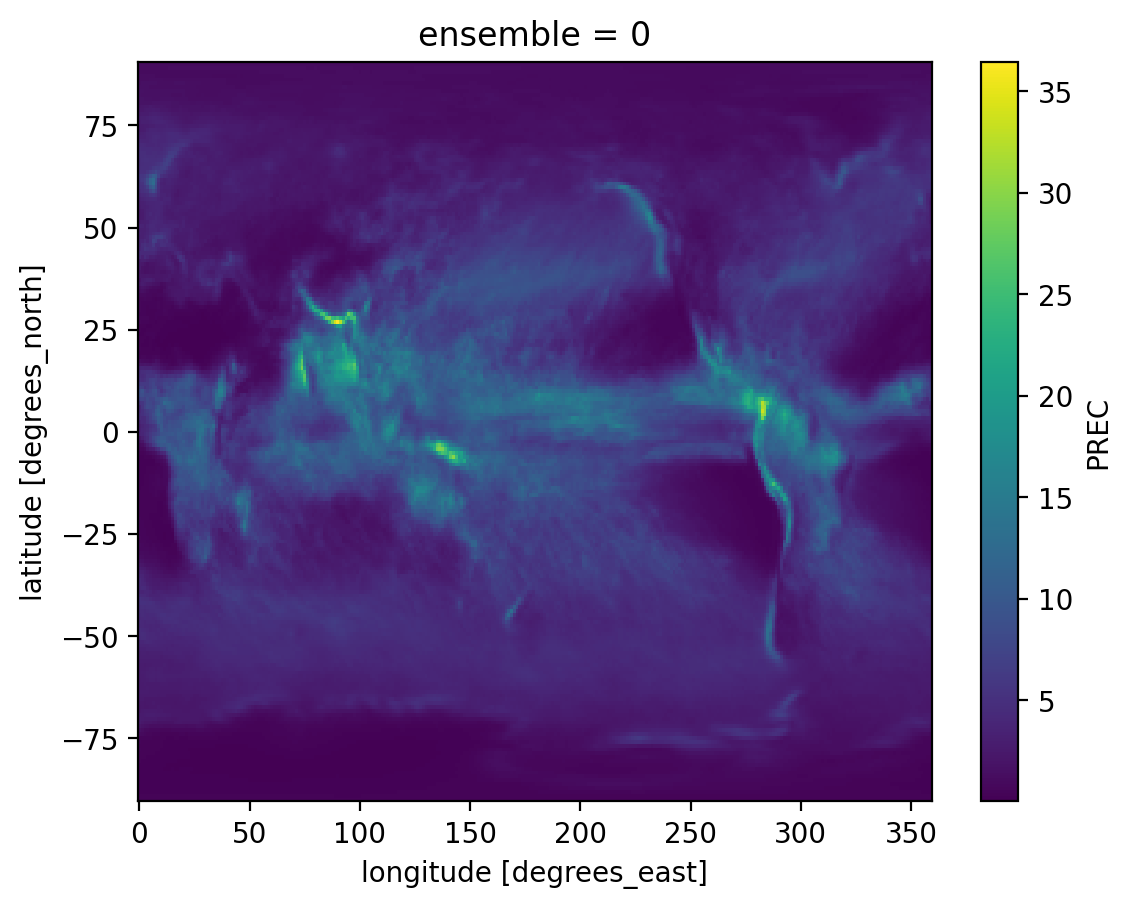

In [50]:
amip_p90['PREC'].sel(ensemble=0).plot()